# Mars Terrain Segmentation with U-Net: Bottleneck and Parallel Branches  

This notebook demonstrates semantic segmentation of Mars terrain using a U-Net architecture enhanced with a bottleneck containing two parallel branches.

The model categorizes each pixel into its specific soil type, aiding planetary research and exploration.


## 🚀 Setting Up the Environment: Installing Packages and Connecting to Google Drive


In [ ]:
# Install TensorFlow Addons package
!pip install tfa-nightly keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.8 MB/s eta 0:00:00


### Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


### Import Libraries

In [ ]:
from keras import backend as K
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from time import time

import keras_cv
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import warnings

In [ ]:
# Set seed for reproducibility
seed = 42

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Set seeds for random number generators in NumPy and Python
random.seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')

print(f'X_test Shape: {X_test.shape}')

X_train Shape: (2615, 64, 128)
y_train Shape: (2615, 64, 128)
X_test Shape: (10022, 64, 128)


### Define Model Parameters

In [ ]:
# Set batch size for training
BATCH_SIZE = 256

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

NUM_CLASSES=5

## 👀 Inspect the Data

In [ ]:
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        colormap = plt.cm.viridis(np.linspace(0, 1, NUM_CLASSES))

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [ ]:
# NB: This function should be modified so as to employ the same color mapping used later on in the notebook

def display_images_and_masks(images,
                             masks,
                             num_images=10,
                             random_images=False,
                             show_index=False):

    if random_images:
        indices = random.sample(range(len(images)), num_images)
    else:
        indices = range(num_images)

    for i, idx in enumerate(indices):
        plt.figure(figsize=(8, 4))

        if show_index:
            print(f'Image Index: {idx}')

        plt.subplot(1, 2, 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(apply_colormap(masks[idx]), cmap='viridis') # To be modified
        plt.title('Mask')
        plt.axis('off')

        plt.show()

### Show different class distributions

In [ ]:
def calculate_class_percentage(y_train):
    # Flatten y_train to aggregate pixel counts across all segmented images
    all_pixels = np.concatenate([y.flatten() for y in y_train])

    # Count the occurrences of each class
    unique_classes, counts = np.unique(all_pixels, return_counts=True)

    # Calculate the total number of pixels
    total_pixels = all_pixels.size

    # Calculate the percentage of each class
    class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

    return class_percentages

class_percentages = calculate_class_percentage(y_train)

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 0.0: 25.52%
Class 1.0: 33.29%
Class 2.0: 22.71%
Class 3.0: 18.36%
Class 4.0: 0.13%


Image Index: 1393


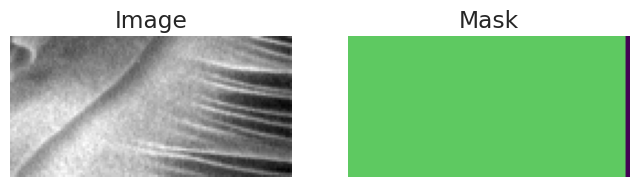

Image Index: 1138


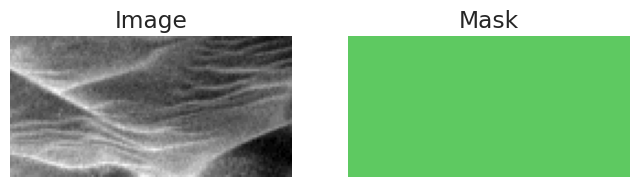

Image Index: 636


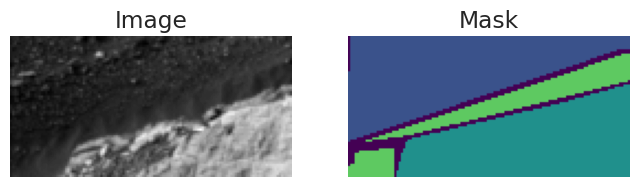

Image Index: 881


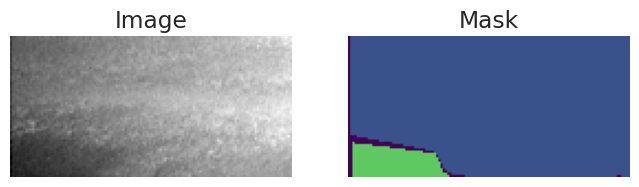

Image Index: 1378


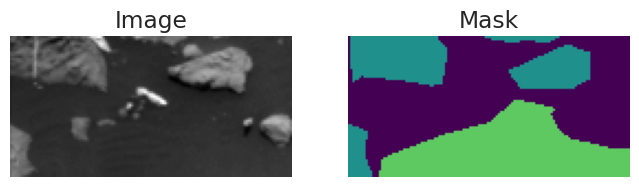

Image Index: 418


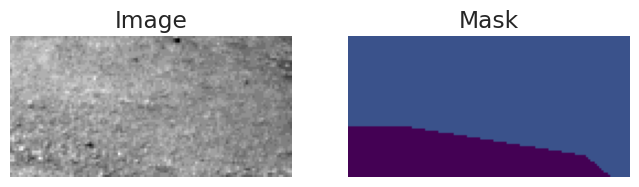

Image Index: 379


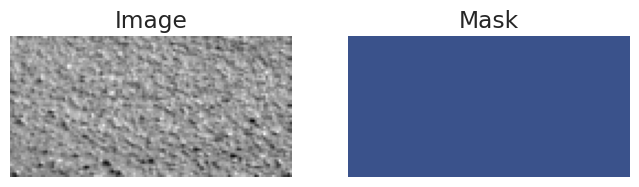

Image Index: 1556


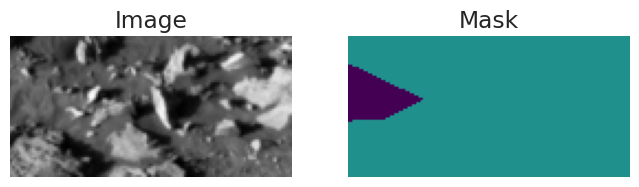

Image Index: 396


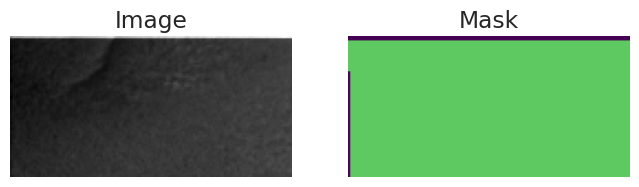

Image Index: 1470


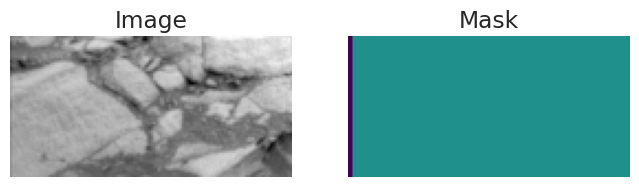

In [ ]:
display_images_and_masks(X_train, y_train, random_images=True, show_index=True)

### Show evidence of alien's presence on Mars

Number of detected images having reference_mask as mask: 110


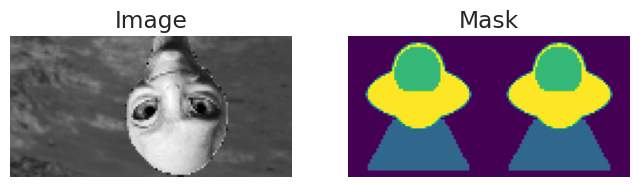

In [ ]:
reference_mask = y_train[62]

boolean_mask = [np.array_equal(mask, reference_mask) for mask in y_train]
indices = [boolean_mask.index(i) for i in boolean_mask if i == True]

print(f'Number of detected images having reference_mask as mask: {len(indices)}')

X_outliers = X_train[indices]
y_outliers = y_train[indices]

display_images_and_masks(X_outliers, y_outliers, num_images=1)

In [ ]:
target_class = 4
num_images_with_class = sum(target_class in np.unique(y) for y in y_train)
print(f"The class {target_class} is present in {num_images_with_class} images.")

# Find indices of the images containing pixels labelled as target class
indices_with_class = [idx for idx, y in enumerate(y_train) if target_class in np.unique(y)]

for idx in indices_with_class:
    plt.figure(figsize=(8, 4))

    print("Img " + str(idx))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title("Image")
    plt.axis('off')

    # Mask
    plt.subplot(1, 2, 2)
    colormap = plt.cm.viridis(np.linspace(0, 1, 5))
    colored_label = apply_colormap(y_train[idx], colormap)
    plt.imshow(colored_label)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 🧹 Clean the Data

### Remove evidence of alien's presence on Mars

In [ ]:
# Get the reference label (y_train[62])
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
boolean_mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

X_train = X_train[boolean_mask]
y_train = y_train[boolean_mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


In [ ]:
def calculate_class_percentage(y_train):
    # Flatten y_train to aggregate pixel counts across all segmented images
    all_pixels = np.concatenate([y.flatten() for y in y_train])

    # Count the occurrences of each class
    unique_classes, counts = np.unique(all_pixels, return_counts=True)

    # Calculate the total number of pixels
    total_pixels = all_pixels.size

    # Calculate the percentage of each class
    class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

    return class_percentages

class_percentages = calculate_class_percentage(y_train)

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [ ]:
def cleaning_background(label):
    # Count the number of pixels for each class
    unique, counts = np.unique(label, return_counts=True)
    class_counts = dict(zip(unique, counts))

    # Remove class 0 from count to find the prevailing class
    class_counts.pop(0, None)  # Ignore class 0
    if class_counts:
        # Find the prevailing class
        major_class = max(class_counts, key=class_counts.get)
    else:
        # If the only class is 0, replace it with class 1
        major_class = 1

    # Replace pixels of class 0 with prevailing class
    updated_label = np.where(label == 0, major_class, label)

    return updated_label

### Selectively remove class 0

341
Img 0 contains background


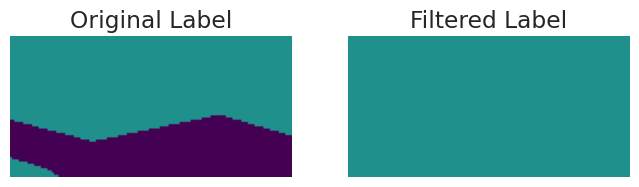

Img 1 contains background


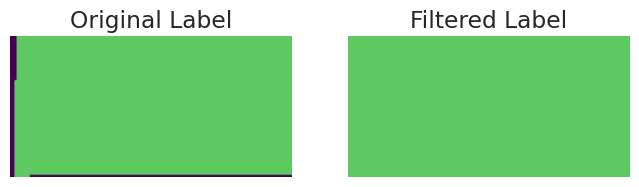

Img 5 contains background


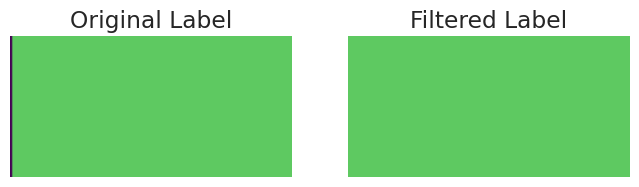

Img 6 contains background


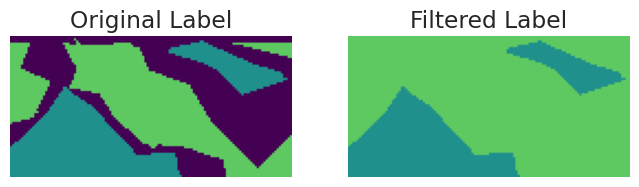

Img 9 contains background


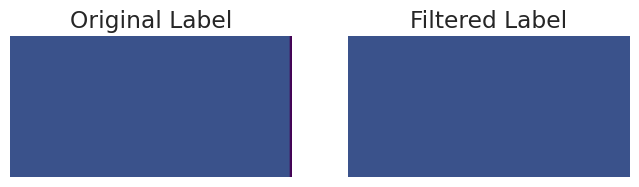

Img 10 contains background


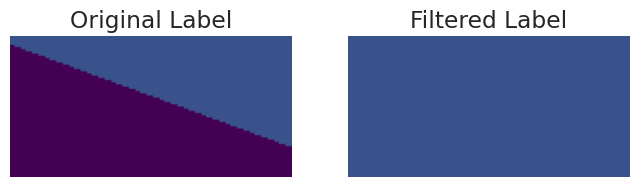

Img 11 contains background


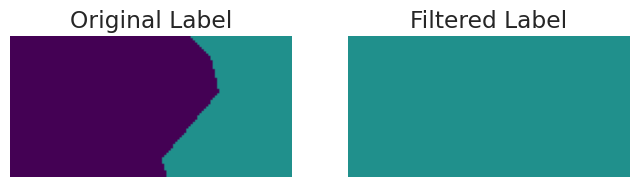

Img 12 contains background


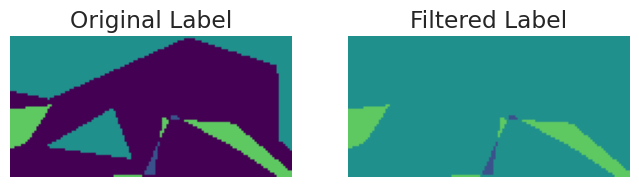

Img 14 contains background


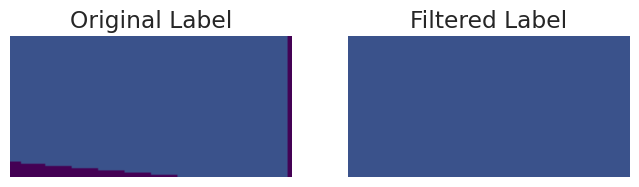

Img 15 contains background


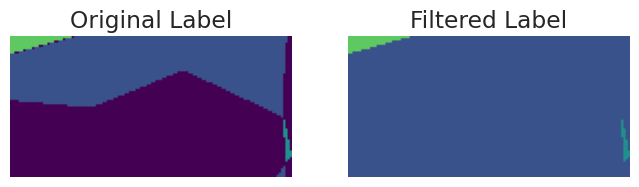

Img 16 contains background


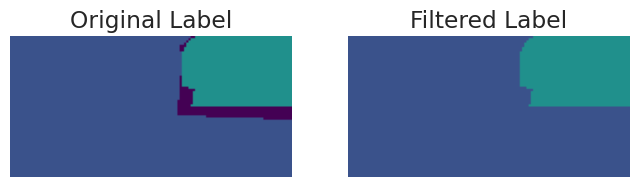

Img 17 contains background


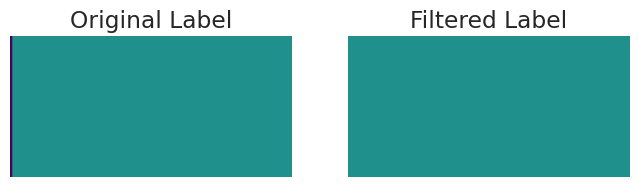

Img 18 contains background


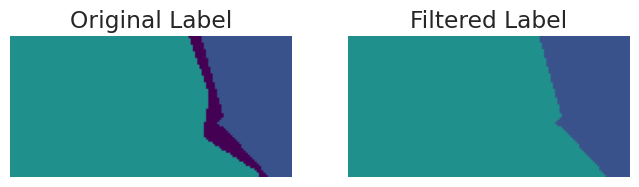

Img 20 contains background


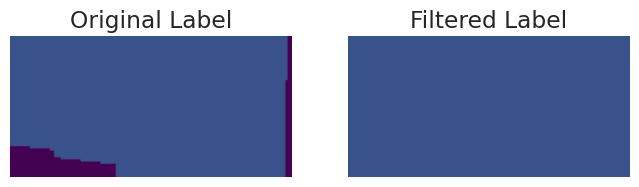

Img 21 contains background


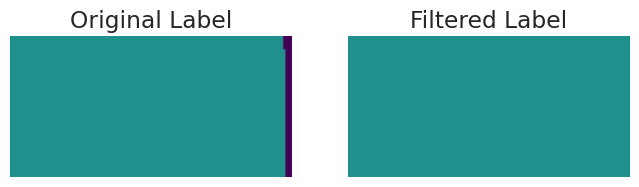

Img 23 contains background


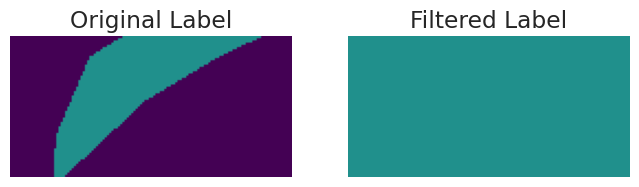

Img 24 contains background


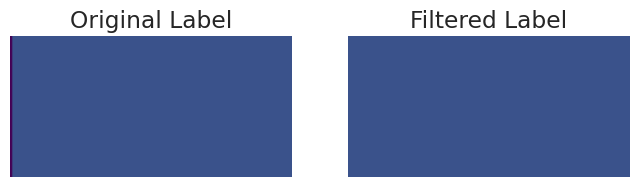

Img 26 contains background


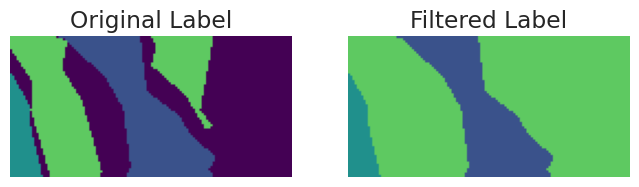

Img 27 contains background


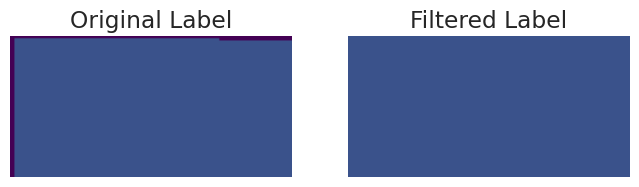

Img 28 contains background


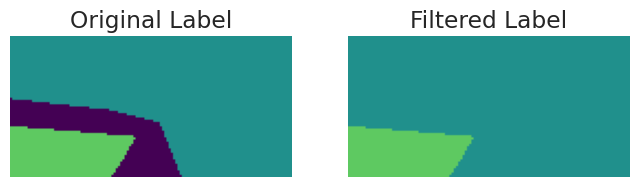

Img 29 contains background


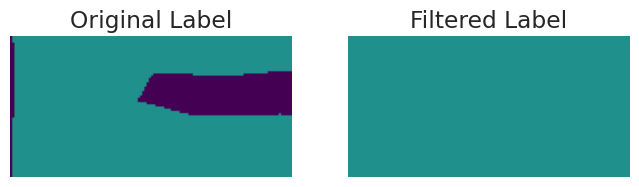

Img 31 contains background


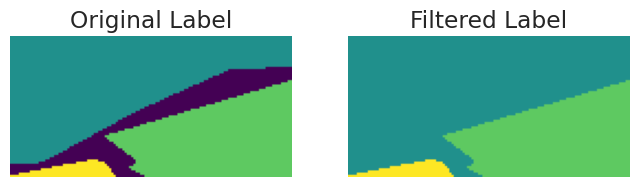

Img 32 contains background


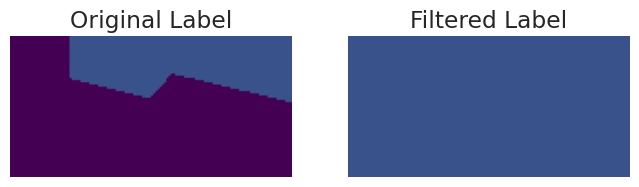

Img 33 contains background


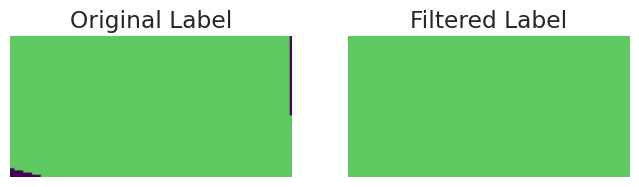

Img 34 contains background


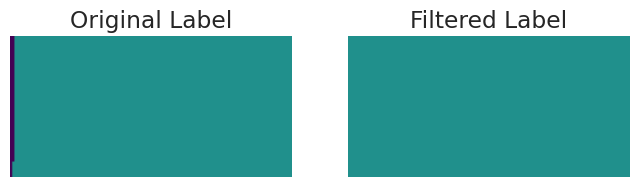

Img 35 contains background


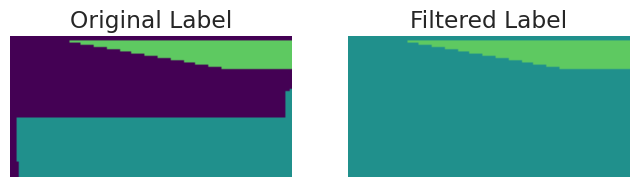

Img 36 contains background


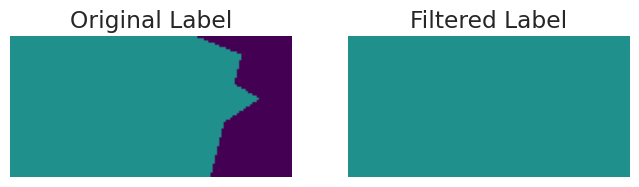

Img 37 contains background


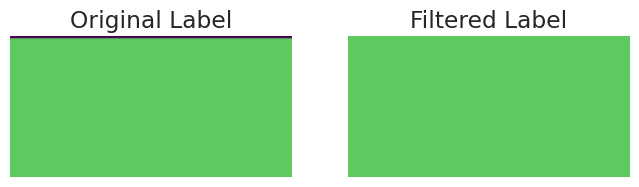

Img 38 contains background


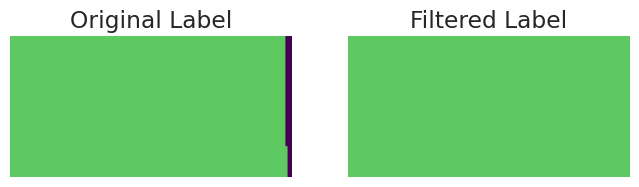

Img 40 contains background


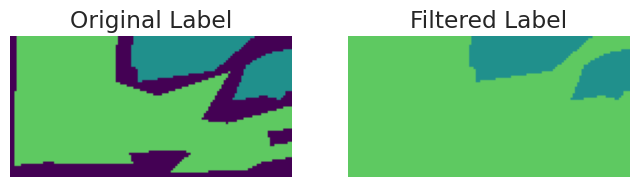

Img 41 contains background


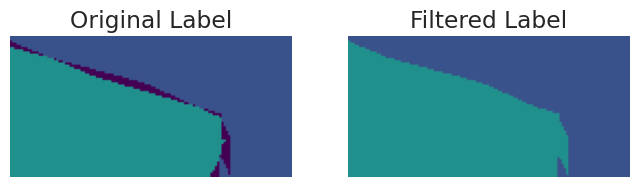

Img 45 contains background


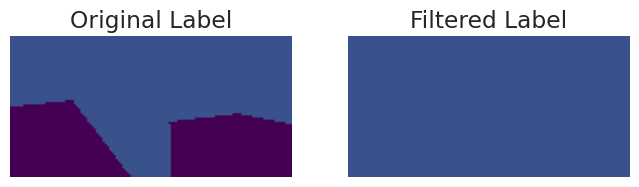

Img 47 contains background


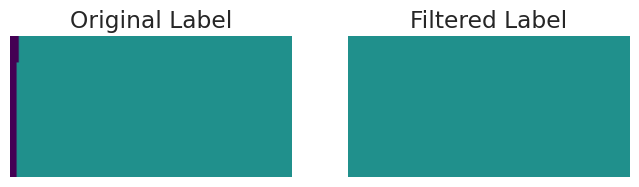

Img 48 contains background


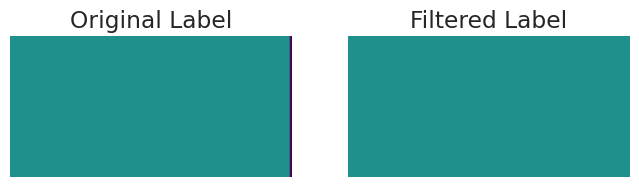

Img 49 contains background


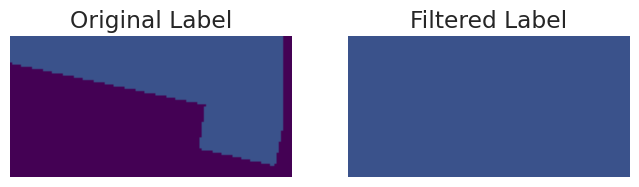

Img 50 contains background
Img 51 contains background
Img 54 contains background
Img 56 contains background
Img 57 contains background
Img 58 contains background
Img 59 contains background
Img 60 contains background
Img 64 contains background
Img 67 contains background
Img 69 contains background
Img 70 contains background
Img 71 contains background
Img 72 contains background
Img 74 contains background
Img 75 contains background
Img 76 contains background
Img 77 contains background
Img 78 contains background
Img 79 contains background
Img 80 contains background
Img 83 contains background
Img 84 contains background
Img 85 contains background
Img 87 contains background
Img 88 contains background
Img 90 contains background
Img 91 contains background
Img 92 contains background
Img 93 contains background
Img 96 contains background
Img 97 contains background
Img 98 contains background
Img 99 contains background
Img 101 contains background
Img 102 contains background
Img 103 contains backgroun

In [ ]:
# Indexes of pictures in which class 0 is in our opinion uncorrectly segmented
idx_background = [10, 11,12,15,23,26, 32,35,49,57,58,67,72,76,
                  84,90,105,106,115,116,133,140,145,149,158,162,164,166,170,182,191,194,
                  201,202,208,212,214,226,237,241,261,266,270,273,280,287,290,297,307,308,321,
                  325,326,339,342,364,368,382,385,386,388,397,399,406,414,423,427,428,
                  432,439,441,445,446,452,458,471,480,495,497,499,502,513,545,547,556,557,564,
                  560,591,601,602,605,614,626,632,654,655,660,674,683,685,692,693,698,
                  711,726,737,742,748,760,766,769,787,794,795,797,804,807,813,816,
                  824,833,843,848,850,851,867,868,872,873,874,881,882,887,888,915,918,920,
                  927,930,935,937,942,948,955,956,957,960,990,999,1022,1023,1026,1028,1030,1035,
                  1037,1040,1050,1060,1068,1079,1083,1085,1097,1099,1123,1141,1143,1156,1162,
                  1168,1173,1187,1193,1199,1200,1201,1204,1212,1219,1220,1225,1228,1231,
                  1233,1238,1246,1266,1282,1283,1311,1316,1318,1326,1332,1336,1344,1349,
                  1357,1372,1386,1403,1415,1426,1443,1456,1462,1464,1466,1469,1474,1491,1498,
                  1501,1508,1510,1514,1527,1534,1539,1540,1544,1548,1569,1572,1576,1585,
                  1587,1590,1593,1609,1617,1618,1627,1632,1646,1656,1681,1698,1702,1708,
                  1712,1751,1755,1756,1781,1786,1795,1808,1818,1824,1826,1832,1839,1841,
                  1853,1854,1866,1872,1900,1913,1917,1919,1942,1947,1952,1955,1960,1967,
                  1978,1982,1986,1990,1991,2000,2002,2003,2004,2014,2024,2029,2034,2048,
                  2050,2064,2065,2070,2071,2079,2087,2091,2106,2111,2115,2123,2124,2149,
                  2160,2163,2168,2171,2184,2185,2192,2193,2197,2199,2218,2225,2232,2234,
                  2246,2247,2253,2266,2287,2301,2308,2311,2313,2330,2331,2337,2354,2363,2365,
                  2369,2383,2399,2406,2409,2412,2414,2420,2432,2445,2451,2456,2473,2498]

print(len(idx_background))

# Parameters
label_value = 0  # Label of interest
threshold_percentage = 40

# Iterate over all images and masks
for i, (img_batch, lbl_batch) in enumerate(zip(X_train, y_train)):
    # Check if any pixel in the label belongs to class 4
    if np.any(lbl_batch == label_value):  # Check if class 4 is present in the label

        total_pixels = 64 * 128
        label_pixels = np.sum(lbl_batch == label_value)
        label_percentage = (label_pixels / total_pixels) * 100

        if (label_percentage > 0.0) and ((label_percentage <= threshold_percentage) or i in idx_background):
            new_label = cleaning_background(lbl_batch)
            print(f"Img {i} contains background")

            if i < 50:
                # Apply the colormap to the segmentation labels
                colormap = plt.cm.viridis(np.linspace(0, 1, 5))

                # Plot original image
                plt.figure(figsize=(8, 4))

                plt.subplot(1, 2, 1)
                colored_label = apply_colormap(lbl_batch, colormap)
                plt.imshow(colored_label, cmap='viridis')
                plt.title("Original Label")
                plt.axis('off')


                plt.subplot(1, 2, 2)
                colored_label = apply_colormap(new_label, colormap)
                plt.imshow(colored_label, cmap='viridis')
                plt.title("Filtered Label")
                plt.axis('off')

                plt.show()

            y_train[i] = new_label


### Splitting in training, validation e test set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

In [ ]:
X_train, X_test2, y_train, y_test2 = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

In [ ]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

## 🔄 Data Augmentation: Enhancing the Dataset

In [ ]:
@tf.function
def random_rotate_translate(image, label, seed=None):
    """Apply random rotation and translation."""

    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, label

In [ ]:
def plot_images_from_dataset(dataset, num_images=5):
    """
    Plots a few images with their labels from a TensorFlow dataset.

    Args:
        dataset: A TensorFlow dataset containing images and labels.
        num_images: Number of images to display.
    """
    # Iterate through the dataset to extract images and labels
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Immagine originale
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Immagine")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        colormap = plt.cm.viridis(np.linspace(0, 1, 5))
        colored_label = apply_colormap(tf.math.argmax(label, axis=-1), colormap)
        plt.imshow(colored_label)
        plt.title("Ground Truth Mask")
        plt.axis('off')

    plt.show()

### Create dataset with augmentations

In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    mask4 = [idx for idx in range(len(images)) if 4 in np.unique(labels[idx])]

    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)

    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels

    # Trova gli indici delle immagini che contengono la classe target
    class4_dataset = tf.data.Dataset.from_tensor_slices((tf.gather(images, mask4), tf.gather(labels, mask4)))
    class4_dataset = class4_dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset2 = dataset.map(
            lambda x, y: random_rotate_translate(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.concatenate(dataset2)


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)


val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    seed=seed
)


test_dataset = make_dataset(
    X_test2, y_test2,
    batch_size=25,
    shuffle=True,
    seed=seed
)

In [ ]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)

Image batch shape: (256, 64, 128, 1)
Label batch shape: (256, 64, 128, 5)


## 🏗️ Building the Model

In [ ]:
def unet_block(input_tensor,
               filters,
               kernel_size=3,
               activation='relu',
               dropout_rate=0,
               stack=1,
               name=''):

    # Initialize the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=(1, 1),
                        padding='same',
                        kernel_initializer='HeNormal',
                        name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation=activation,
                            name=name + 'activation' + str(i + 1))(x)
        if dropout_rate > 0:
            x = tfkl.Dropout(dropout_rate, name=name + 'dropout')(x)

    # Return the transformed tensor
    return x

In [ ]:
def upsampling_block(input_tensor,
                     down_block,
                     filters,
                     kernel_size=2,
                     activation='relu',
                     kernel_initializer='HeNormal',
                     stack=1,
                     name=''):

    # Initialize the Input Tensor
    x = input_tensor

    # Apply a sequence of Conv2DTranspose and Concatenate for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2DTranspose(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=(2, 2),
                                 padding='same',
                                 kernel_initializer=kernel_initializer,
                                 name=name + 'conv_transpose'+ str(i + 1))(x)
        x = tfkl.Concatenate()([x, down_block])

    return x

### Squeeze-and-Excitation Block (SENet, 2017)

In [ ]:
def se_block(x, filters,
                kernel_size=3,
                padding='same',
                downsample=True,
                activation='relu',
                stack=2,
                name='senet'):

    for s in range(stack):
        # Squeeze-and-Excitation (SE) Module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)

        # Excitation step (Compress the information: reduce the number channels)
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        # Scaling the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x, se])

    # Optional Downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [ ]:
def unet_gating_signal(input_tensor, batch_norm=True, name=''):
    input_shape = input_tensor.shape
    x = tfkl.Conv2D(filters=input_shape[3] * 1,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer='HeNormal',
                    name=name + '_conv')(input_tensor)
    if batch_norm:
        x = tfkl.BatchNormalization(name=name + '_bn')(x)
    x = tfkl.Activation(activation='relu', name=name + '_act')(x)
    return x

In [ ]:
def attention_gate_block(x, g, inter_shape, batch_norm=True, dropout_rate=0, name=''):
    x_shape = x.shape
    g_shape = g.shape

    theta_x = tfkl.Conv2D(inter_shape,
                          kernel_size=(2, 2),
                          strides=(2, 2),
                          padding='same',
                          name='xl' + name)(x)
    theta_x_shape = theta_x.shape

    phi_g = tfkl.Conv2D(inter_shape,
                        kernel_size=(1, 1),
                        strides=(1, 1),
                        padding='same')(g)
    upsample_g = tfkl.Conv2DTranspose(inter_shape,
                                      kernel_size=(3, 3),
                                      strides=(theta_x_shape[1] // g_shape[1],
                                               theta_x_shape[2] // g_shape[2]),
                                      padding='same',
                                      name='g_up' + name)(phi_g)

    concat_xg = tfkl.Add()([theta_x, upsample_g])
    act_xg = tfkl.Activation(activation='relu')(concat_xg)

    psi = tfkl.Conv2D(filters=1,
                      kernel_size=(1, 1),
                      strides=(1, 1),
                      padding='same',
                      name='psi'+ name)(act_xg)
    sigmoid_xg = tfkl.Activation(activation='sigmoid')(psi)

    sigmoid_xg_shape = sigmoid_xg.shape
    upsample_psi = tfkl.UpSampling2D(size=(x_shape[1] // sigmoid_xg_shape[1],
                                           x_shape[2] // sigmoid_xg_shape[2]))(sigmoid_xg)

    y = tfkl.Multiply(name='q_attn' + name)([x, upsample_psi])
    result = tfkl.Conv2D(filters=x_shape[3],
                         kernel_size=(1, 1),
                         strides=(1, 1),
                         padding='same',
                         name='q_attn_conv' + name)(y)
    # Optional Layer
    if batch_norm:
        result = tfkl.BatchNormalization(name='q_attn_bn' + name)(result)

    if dropout_rate > 0:
        result = tfkl.Dropout(dropout_rate, name=name + 'dropout')(result)

    return result

In [ ]:
def attn_upsampling_block(input_tensor,
                     concat_block,
                     filters=64,
                     kernel_size=3,
                     padding='same',
                     activation='relu',
                     kernel_initializer='HeNormal',
                     name=''):

    # Initialize the Input Tensor
    x = input_tensor

    # Apply a sequence of Conv2DTranspose and Concatenate for the specified number of stacks
    x = tfkl.Conv2DTranspose(filters=filters,
                             kernel_size=kernel_size,
                             strides=(2, 2),
                             padding=padding,
                             activation=activation,
                             kernel_initializer=kernel_initializer,
                             name=name + 'conv_transpose')(x)
    x = tfkl.Concatenate(name=name + 'concat')([concat_block, x])

    return x

In [ ]:
def augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomBrightness(0.1),
        keras_cv.layers.RandomContrast([0, 255], 0.2),
        keras_cv.layers.RandomGaussianBlur(2, 1),
        tf.keras.layers.GaussianNoise(0.05)
    ])

In [ ]:
def build_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    input_layer = augmentation_layer()(input_layer)

    # Compression Path

    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # Additional downsampling block
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # Another additional downsampling block
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    global_context = unet_block(d4, 512, name='global_context', stack=2)
    parallel_global_context = unet_block(global_context, 512,
                                         name='parallel_global_context', stack=2)
    senet_block = se_block(global_context, 1024, downsample=False, stack=2)
    bottleneck = tfkl.Concatenate()([parallel_global_context, senet_block])

    # Expansion Path

    up_block_4 = upsampling_block(bottleneck, down_block=down_block_4, filters=256, name='up_block4_')
    u4 = unet_block(up_block_4, 256, name='up_block4_')

    up_block_3 = upsampling_block(u4, down_block=down_block_3, filters=128, name='up_block3_')
    u3 = unet_block(up_block_3, 128, name='up_block3_')

    up_block_2 = upsampling_block(u3, down_block=down_block_2, filters=64, name='up_block2_')
    u2 = unet_block(up_block_2, 64, name='up_block2_')

    up_block_1 = upsampling_block(u2, down_block=down_block_1, filters=32, name='up_block1_')
    u1 = unet_block(up_block_1, 32, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_model()
    model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_776CL… │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        320 │ keras_tensor_776… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_49    │ (None, 32, 64,    │          0 │ down_block1_acti… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     18,496 │ max_pooling2d_49… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 16, 32,    │          0 │ down_block2_acti… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_conv1   │ (None, 16, 32,    │     73,856 │ max_pooling2d_50… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_bn1     │ (None, 16, 32,    │        512 │ down_block3_conv… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_activa… │ (None, 16, 32,    │          0 │ down_block3_bn1[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_51    │ (None, 8, 16,     │          0 │ down_block3_acti… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block4_conv1   │ (None, 8, 16,     │    295,168 │ max_pooling2d_51… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block4_bn1     │ (None, 8, 16,     │      1,024 │ down_block4_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block4_activa… │ (None, 8, 16,     │          0 │ down_block4_bn1[… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 4, 8, 256) │          0 │ down_block4_acti

 Total params: 10,731,173 (40.94 MB)

 Trainable params: 10,725,157 (40.91 MB)

 Non-trainable params: 6,016 (23.50 KB)

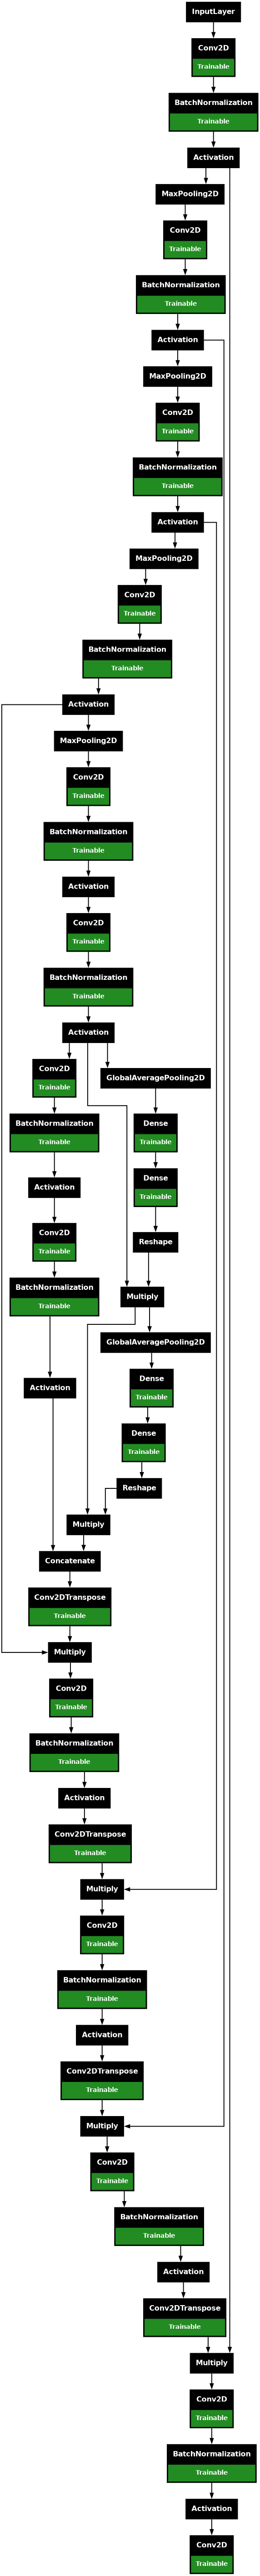

In [ ]:
tfk.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

## 🛠️ Training the Model

### Defining the callbacks

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)

        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

        # Apply the colormap
        colored = colormap[label.astype(int)]

        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]

            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

### Defining the loss functions

In [ ]:
total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}

# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)
class_weights_tensor = class_weights_tensor / tf.norm(class_weights_tensor)

def compute_distance_map(y_true):
    """
    Approximate the distance map using TensorFlow operations.
    This applies a convolution-based smoothing filter.
    """
    # Ensure y_true is one-hot encoded and float
    y_true = tf.cast(y_true, tf.float32)

    # Define a simple Gaussian kernel for smoothing
    def gaussian_kernel(size: int, sigma: float):
        """
        Create a 2D Gaussian kernel using TensorFlow.
        """
        x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        y = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        x, y = tf.meshgrid(x, y)
        kernel = tf.exp(-(x**2 + y**2) / (2.0 * sigma**2))
        kernel = kernel / tf.reduce_sum(kernel)
        return kernel

    kernel_size = 15
    sigma = 5.0
    gaussian = gaussian_kernel(kernel_size, sigma)
    gaussian = gaussian[:, :, tf.newaxis, tf.newaxis]

    distances = []
    for c in range(y_true.shape[-1]):
        class_map = y_true[..., c: c + 1]  # Extract single class channel
        # Apply Gaussian smoothing using 2D convolution
        smoothed = tf.nn.conv2d(
            class_map[tf.newaxis],  # Add batch dimension
            gaussian,
            strides=[1, 1, 1, 1],
            padding="SAME"
        )[0]  # Remove batch dimension
        distances.append(smoothed)

    return tf.stack(distances, axis=-1)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Ensure predictions are within valid probability range
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute cross-entropy
    cross_entropy = -y_true * tf.math.log(y_pred)

    # Compute the focal weight
    focal_weight = alpha * tf.pow(1 - y_pred, gamma)

    # Apply the focal weight to the cross-entropy
    loss = focal_weight * cross_entropy

    # Take the mean over all classes
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Clip the predictions to avoid log(0) errors
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute categorical cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

    # Apply class weights: element-wise multiplication
    # class_weights should be broadcastable to match the shape of y_true
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)  # Weighting for each sample in the batch

    # Compute the weighted loss by multiplying cross-entropy by the weights
    weighted_cross_entropy = weights * cross_entropy

    # Return the mean of the weighted loss over the batch
    return tf.reduce_mean(weighted_cross_entropy)


@tf.function
def dice_loss(y_pred, y_true):

    epsilon = 1e-6  # Per evitare divisioni per zero

    intersection = tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    pred_sum = tf.reduce_sum(y_pred**2, axis=(0, 1, 2))
    true_sum = tf.reduce_sum(y_true**2, axis=(0, 1, 2))

    dice = (2.0 * intersection + epsilon) / (pred_sum + true_sum + epsilon)

    loss = 1.0 - tf.reduce_mean(dice)
    return loss


def boundary_loss(y_true, y_pred):
    """
    Boundary Loss: Penalizes differences along the boundary.
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute distance map
    distance_map = compute_distance_map(y_true)
    distance_map = tf.squeeze(distance_map, axis=3)

    # Compute boundary loss as the L2 loss between distance map and predicted boundaries
    boundary_diff = distance_map * (y_true - y_pred)
    boundary_loss_value = tf.reduce_mean(tf.square(boundary_diff))
    return boundary_loss_value

@tf.function
def combined_loss(y_true, y_pred):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss + Boundary Loss
    """
    loss_ce = weighted_categorical_crossentropy(y_true, y_pred)
    loss_focal = focal_loss(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)

    return loss_ce + 2 * loss_focal + loss_dice

### Compile the model

In [ ]:
# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=[
            MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]),
            tf.keras.metrics.IoU(NUM_CLASSES, [1], name="class1", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [2], name="class2", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [3], name="class3", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [4], name="class4", sparse_y_true=False, sparse_y_pred=False)
        ]
    )
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_iou',
        mode='max',
        patience=PATIENCE,
        restore_best_weights=True
    )

    viz_callback = VizCallback(X_val, y_val)

### Train the model

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - class1: 0.0083 - class2: 0.0947 - class3: 0.0110 - class4: 0.0018 - loss: 1.2799 - mean_iou: 0.0240

W0000 00:00:1733946872.244942      23 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 1 } dim { size: 64 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 1 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipro

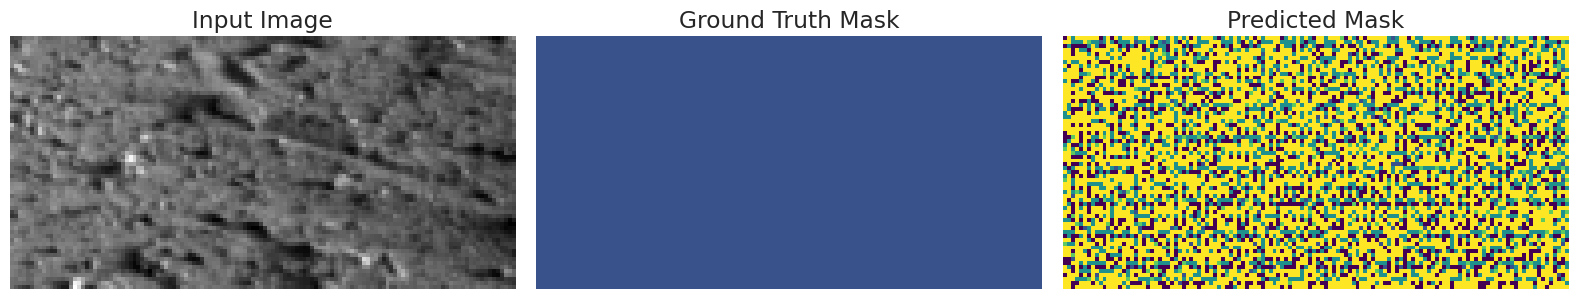

15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 726ms/step - class1: 0.0085 - class2: 0.0959 - class3: 0.0110 - class4: 0.0018 - loss: 1.2797 - mean_iou: 0.0243 - val_class1: 0.0115 - val_class2: 0.1416 - val_class3: 0.0220 - val_class4: 0.0024 - val_loss: 7.8643 - val_mean_iou: 0.0376
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - class1: 0.0323 - class2: 0.2295 - class3: 0.0273 - class4: 0.0039 - loss: 1.2672 - mean_iou: 0.0618 - val_class1: 0.0148 - val_class2: 0.1278 - val_class3: 0.0148 - val_class4: 5.5346e-04 - val_loss: 6.7709 - val_mean_iou: 0.0330
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - class1: 0.1726 - class2: 0.2166 - class3: 0.1035 - class4: 0.0075 - loss: 1.2574 - mean_iou: 0.1057 - val_class1: 0.0411 - val_class2: 0.1176 - val_class3: 0.0137 - val_class4: 5.8895e-04 - val_loss: 5.2938 - val_mean_iou: 0.0359
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - class1: 0.2602 - class2: 0.1310 - class3: 0.1311 - class4: 0.0056 - loss: 1.2523 - mean_iou: 0.1111 - 

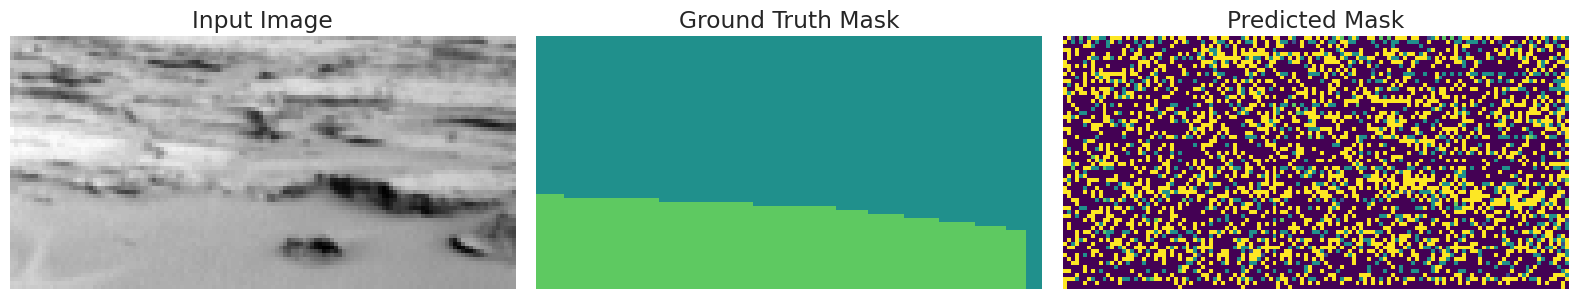

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - class1: 0.2389 - class2: 0.1918 - class3: 0.0941 - class4: 0.0105 - loss: 1.2325 - mean_iou: 0.1117 - val_class1: 0.1731 - val_class2: 0.1085 - val_class3: 0.0199 - val_class4: 0.0022 - val_loss: 1.7768 - val_mean_iou: 0.0625
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.2732 - class2: 0.2072 - class3: 0.1008 - class4: 0.0037 - loss: 1.2161 - mean_iou: 0.1215 - val_class1: 0.1740 - val_class2: 0.1062 - val_class3: 0.0220 - val_class4: 0.0029 - val_loss: 1.6283 - val_mean_iou: 0.0628
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.2832 - class2: 0.2014 - class3: 0.1238 - class4: 0.0154 - loss: 1.2080 - mean_iou: 0.1303 - val_class1: 0.1960 - val_class2: 0.1337 - val_class3: 0.0372 - val_class4: 3.4379e-04 - val_loss: 1.3344 - val_mean_iou: 0.0753
Epoch 9/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - class1: 0.2569 - class2: 0.2202 - class3: 0.1535 - class4: 0.0074 - loss: 1.1903 - mean_iou: 0.1322 - val_c

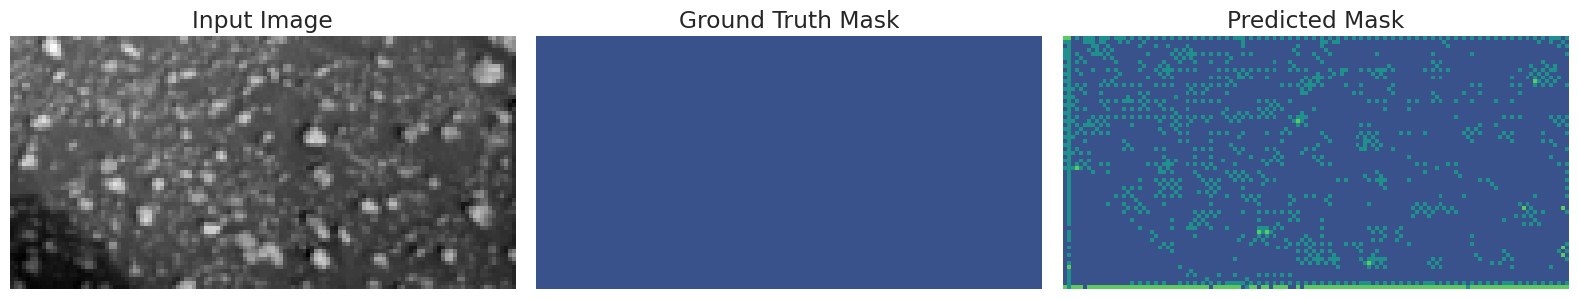

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - class1: 0.2743 - class2: 0.2164 - class3: 0.1634 - class4: 0.0089 - loss: 1.1586 - mean_iou: 0.1372 - val_class1: 0.3705 - val_class2: 0.1449 - val_class3: 0.0258 - val_class4: 0.0030 - val_loss: 1.2723 - val_mean_iou: 0.1124
Epoch 12/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - class1: 0.2897 - class2: 0.2185 - class3: 0.1270 - class4: 0.0094 - loss: 1.1476 - mean_iou: 0.1330 - val_class1: 0.4096 - val_class2: 0.1506 - val_class3: 0.0529 - val_class4: 0.0088 - val_loss: 1.1860 - val_mean_iou: 0.1299
Epoch 13/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - class1: 0.3581 - class2: 0.1687 - class3: 0.1098 - class4: 0.0094 - loss: 1.1276 - mean_iou: 0.1328 - val_class1: 0.4081 - val_class2: 0.1346 - val_class3: 0.0457 - val_class4: 0.0104 - val_loss: 1.2020 - val_mean_iou: 0.1244
Epoch 14/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - class1: 0.3865 - class2: 0.1305 - class3: 0.0919 - class4: 0.0063 - loss: 1.1222 - mean_iou: 0.1265 - val_cl

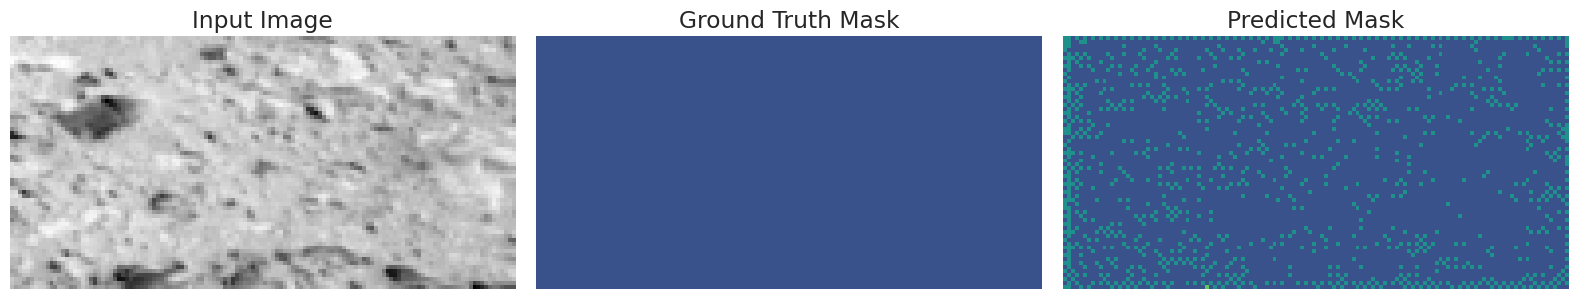

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - class1: 0.4075 - class2: 0.1360 - class3: 0.0731 - class4: 0.0102 - loss: 1.0833 - mean_iou: 0.1280 - val_class1: 0.4301 - val_class2: 0.0733 - val_class3: 0.0312 - val_class4: 2.8339e-04 - val_loss: 1.1732 - val_mean_iou: 0.1122
Epoch 17/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - class1: 0.4090 - class2: 0.1365 - class3: 0.0706 - class4: 0.0091 - loss: 1.0666 - mean_iou: 0.1273 - val_class1: 0.3943 - val_class2: 0.0469 - val_class3: 0.0413 - val_class4: 0.0000e+00 - val_loss: 1.1800 - val_mean_iou: 0.1015
Epoch 18/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - class1: 0.4105 - class2: 0.1425 - class3: 0.0866 - class4: 0.0078 - loss: 1.0561 - mean_iou: 0.1315 - val_class1: 0.4141 - val_class2: 0.0421 - val_class3: 0.0341 - val_class4: 0.0000e+00 - val_loss: 1.1941 - val_mean_iou: 0.1027
Epoch 19/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - class1: 0.4222 - class2: 0.1332 - class3: 0.0880 - class4: 0.0091 - loss: 1.0410 - mean_iou: 0.

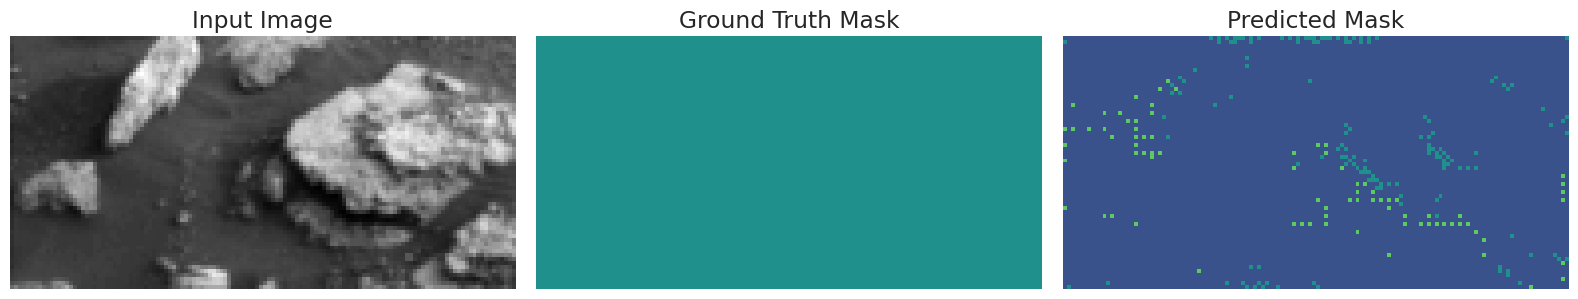

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - class1: 0.4181 - class2: 0.1374 - class3: 0.1120 - class4: 0.0100 - loss: 1.0279 - mean_iou: 0.1374 - val_class1: 0.4479 - val_class2: 0.0359 - val_class3: 0.0391 - val_class4: 9.8367e-05 - val_loss: 1.1335 - val_mean_iou: 0.1084
Epoch 22/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - class1: 0.4284 - class2: 0.1441 - class3: 0.1811 - class4: 0.0108 - loss: 0.9995 - mean_iou: 0.1546 - val_class1: 0.4564 - val_class2: 0.0255 - val_class3: 0.0362 - val_class4: 1.0008e-04 - val_loss: 1.1597 - val_mean_iou: 0.1091
Epoch 23/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.4329 - class2: 0.1711 - class3: 0.2052 - class4: 0.0089 - loss: 0.9815 - mean_iou: 0.1653 - val_class1: 0.4055 - val_class2: 0.0134 - val_class3: 0.0387 - val_class4: 1.7489e-04 - val_loss: 1.1811 - val_mean_iou: 0.1000
Epoch 24/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - class1: 0.4318 - class2: 0.1864 - class3: 0.2092 - class4: 0.0156 - loss: 0.9735 - mean_iou: 0.1

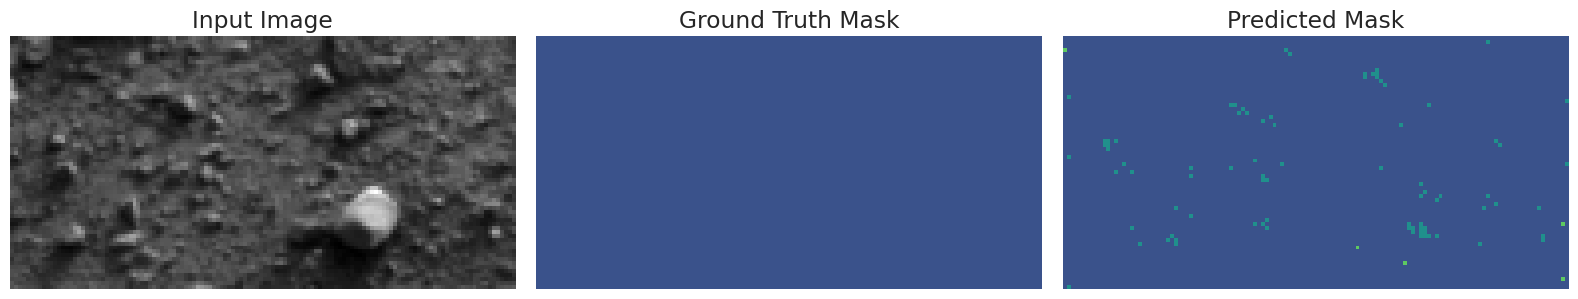

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - class1: 0.4744 - class2: 0.3103 - class3: 0.2719 - class4: 0.0084 - loss: 0.9201 - mean_iou: 0.2157 - val_class1: 0.4208 - val_class2: 0.0035 - val_class3: 0.0061 - val_class4: 0.0000e+00 - val_loss: 1.1773 - val_mean_iou: 0.1222
Epoch 27/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.4779 - class2: 0.3355 - class3: 0.2859 - class4: 0.0181 - loss: 0.8985 - mean_iou: 0.2273 - val_class1: 0.4211 - val_class2: 0.0379 - val_class3: 0.0131 - val_class4: 0.0000e+00 - val_loss: 1.1258 - val_mean_iou: 0.1006
Epoch 28/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.5136 - class2: 0.3915 - class3: 0.2760 - class4: 0.0201 - loss: 0.8692 - mean_iou: 0.2451 - val_class1: 0.4922 - val_class2: 0.1621 - val_class3: 0.0628 - val_class4: 1.5924e-04 - val_loss: 1.1126 - val_mean_iou: 0.1551
Epoch 29/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - class1: 0.5679 - class2: 0.3997 - class3: 0.3494 - class4: 0.0137 - loss: 0.8235 - mean_iou: 0.2

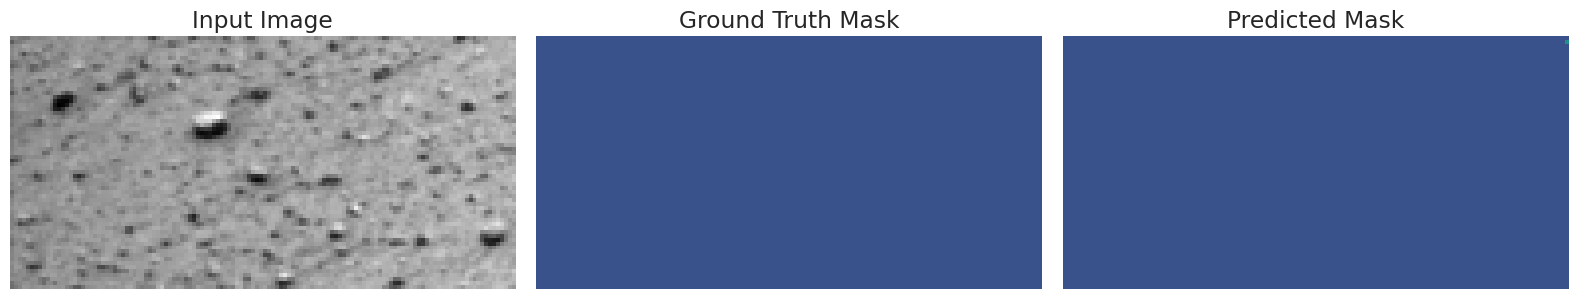

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - class1: 0.6085 - class2: 0.4304 - class3: 0.4237 - class4: 0.0067 - loss: 0.7695 - mean_iou: 0.3008 - val_class1: 0.4214 - val_class2: 0.0094 - val_class3: 0.2034 - val_class4: 0.0000e+00 - val_loss: 1.1389 - val_mean_iou: 0.1382
Epoch 32/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - class1: 0.6179 - class2: 0.4555 - class3: 0.4708 - class4: 0.0118 - loss: 0.7236 - mean_iou: 0.3181 - val_class1: 0.4802 - val_class2: 0.0708 - val_class3: 0.3371 - val_class4: 2.6610e-04 - val_loss: 1.0904 - val_mean_iou: 0.1911
Epoch 33/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - class1: 0.6566 - class2: 0.4889 - class3: 0.5282 - class4: 0.0134 - loss: 0.6781 - mean_iou: 0.3445 - val_class1: 0.4690 - val_class2: 0.1186 - val_class3: 0.3038 - val_class4: 0.0000e+00 - val_loss: 1.0658 - val_mean_iou: 0.1936
Epoch 34/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.6779 - class2: 0.5308 - class3: 0.5282 - class4: 0.0138 - loss: 0.6517 - mean_iou: 0.3

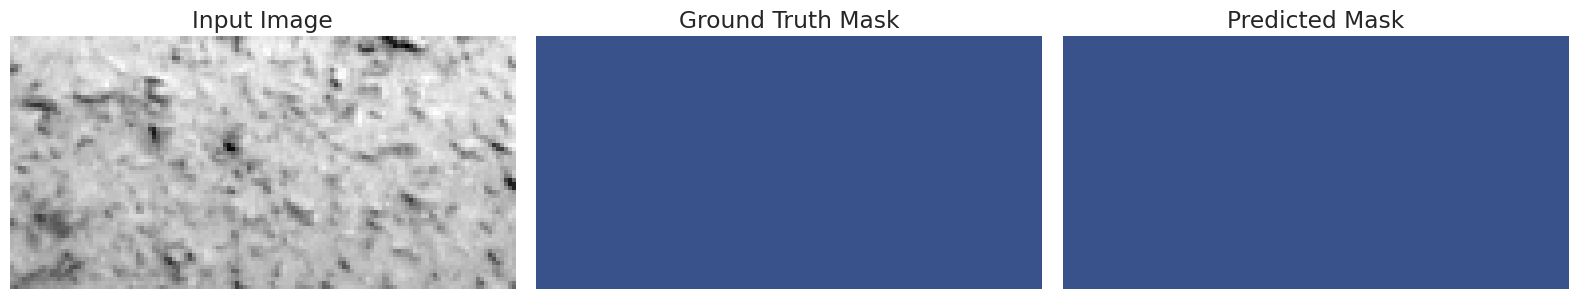

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - class1: 0.7121 - class2: 0.5829 - class3: 0.5781 - class4: 0.0097 - loss: 0.5965 - mean_iou: 0.3835 - val_class1: 0.4703 - val_class2: 0.0556 - val_class3: 0.4909 - val_class4: 1.4493e-04 - val_loss: 1.0360 - val_mean_iou: 0.2214
Epoch 37/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.7305 - class2: 0.6168 - class3: 0.5994 - class4: 0.0114 - loss: 0.5668 - mean_iou: 0.3990 - val_class1: 0.5267 - val_class2: 0.1146 - val_class3: 0.4902 - val_class4: 0.0000e+00 - val_loss: 0.9975 - val_mean_iou: 0.2471
Epoch 38/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - class1: 0.7044 - class2: 0.5878 - class3: 0.6026 - class4: 0.0085 - loss: 0.5787 - mean_iou: 0.3878 - val_class1: 0.5589 - val_class2: 0.1287 - val_class3: 0.5019 - val_class4: 0.0000e+00 - val_loss: 0.9421 - val_mean_iou: 0.2549
Epoch 39/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.7463 - class2: 0.6312 - class3: 0.6242 - class4: 0.0099 - loss: 0.5387 - mean_iou: 0.4

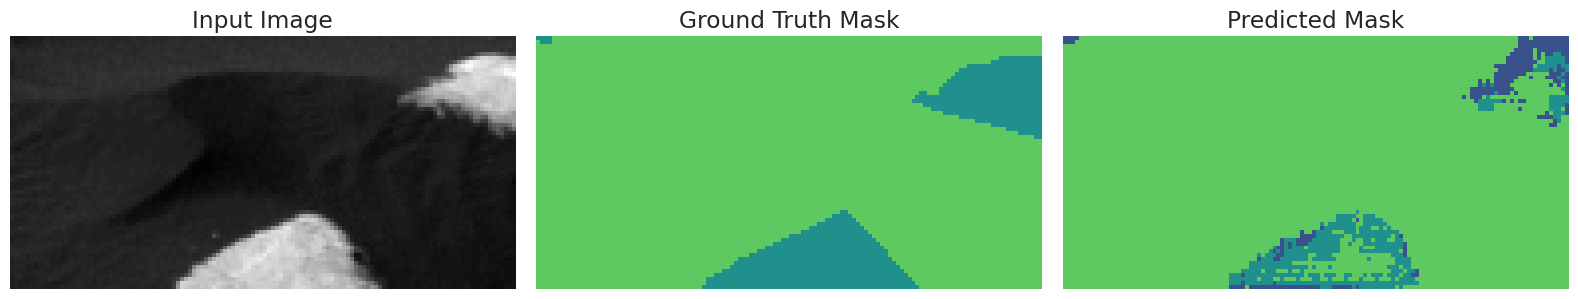

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - class1: 0.7808 - class2: 0.6813 - class3: 0.6687 - class4: 0.0060 - loss: 0.4913 - mean_iou: 0.4333 - val_class1: 0.5586 - val_class2: 0.2575 - val_class3: 0.5442 - val_class4: 0.0000e+00 - val_loss: 0.9107 - val_mean_iou: 0.2921
Epoch 42/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - class1: 0.7624 - class2: 0.6645 - class3: 0.6611 - class4: 0.0034 - loss: 0.5011 - mean_iou: 0.4248 - val_class1: 0.6599 - val_class2: 0.3975 - val_class3: 0.6174 - val_class4: 0.0027 - val_loss: 0.8009 - val_mean_iou: 0.3604
Epoch 43/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - class1: 0.7756 - class2: 0.6757 - class3: 0.6638 - class4: 0.0035 - loss: 0.4916 - mean_iou: 0.4309 - val_class1: 0.6650 - val_class2: 0.3384 - val_class3: 0.5859 - val_class4: 1.7658e-04 - val_loss: 0.7398 - val_mean_iou: 0.3338
Epoch 44/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.7838 - class2: 0.7166 - class3: 0.6747 - class4: 0.0047 - loss: 0.4667 - mean_iou: 0.4425 

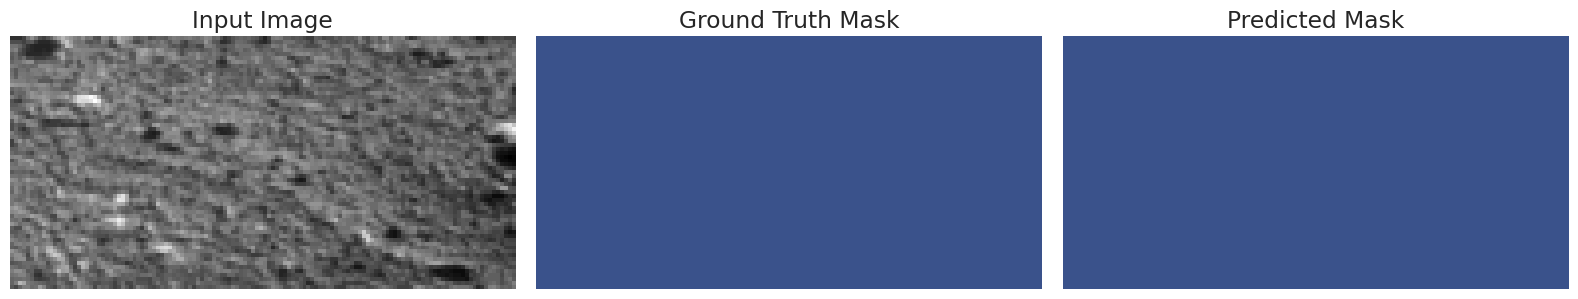

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - class1: 0.7949 - class2: 0.7301 - class3: 0.6902 - class4: 0.0059 - loss: 0.4418 - mean_iou: 0.4492 - val_class1: 0.6458 - val_class2: 0.3905 - val_class3: 0.6426 - val_class4: 0.0038 - val_loss: 0.6937 - val_mean_iou: 0.3492
Epoch 47/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - class1: 0.8225 - class2: 0.7654 - class3: 0.7149 - class4: 0.0050 - loss: 0.4158 - mean_iou: 0.4662 - val_class1: 0.6479 - val_class2: 0.3561 - val_class3: 0.6187 - val_class4: 0.0000e+00 - val_loss: 0.8066 - val_mean_iou: 0.3458
Epoch 48/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - class1: 0.8148 - class2: 0.7630 - class3: 0.7303 - class4: 0.0076 - loss: 0.4141 - mean_iou: 0.4683 - val_class1: 0.6565 - val_class2: 0.3715 - val_class3: 0.4862 - val_class4: 2.1209e-04 - val_loss: 0.8411 - val_mean_iou: 0.3256
Epoch 49/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - class1: 0.8177 - class2: 0.7764 - class3: 0.7167 - class4: 0.0037 - loss: 0.4148 - mean_iou: 0.4674 

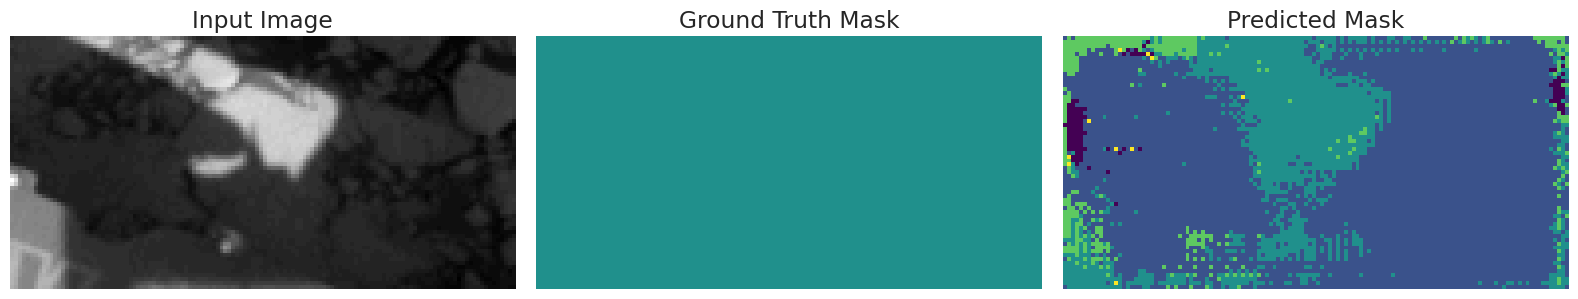

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - class1: 0.8136 - class2: 0.7716 - class3: 0.7293 - class4: 0.0034 - loss: 0.4114 - mean_iou: 0.4687 - val_class1: 0.6831 - val_class2: 0.5459 - val_class3: 0.4801 - val_class4: 0.0000e+00 - val_loss: 0.7269 - val_mean_iou: 0.3550
Epoch 52/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - class1: 0.8357 - class2: 0.7812 - class3: 0.7460 - class4: 0.0053 - loss: 0.3972 - mean_iou: 0.4792 - val_class1: 0.6255 - val_class2: 0.3469 - val_class3: 0.6353 - val_class4: 0.0000e+00 - val_loss: 0.7782 - val_mean_iou: 0.3377
Epoch 53/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.8363 - class2: 0.7951 - class3: 0.7388 - class4: 0.0054 - loss: 0.3904 - mean_iou: 0.4803 - val_class1: 0.6501 - val_class2: 0.3078 - val_class3: 0.5919 - val_class4: 7.6017e-04 - val_loss: 0.8141 - val_mean_iou: 0.3262
Epoch 54/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.8094 - class2: 0.7518 - class3: 0.7475 - class4: 0.0026 - loss: 0.4076 - mean_iou: 0.4

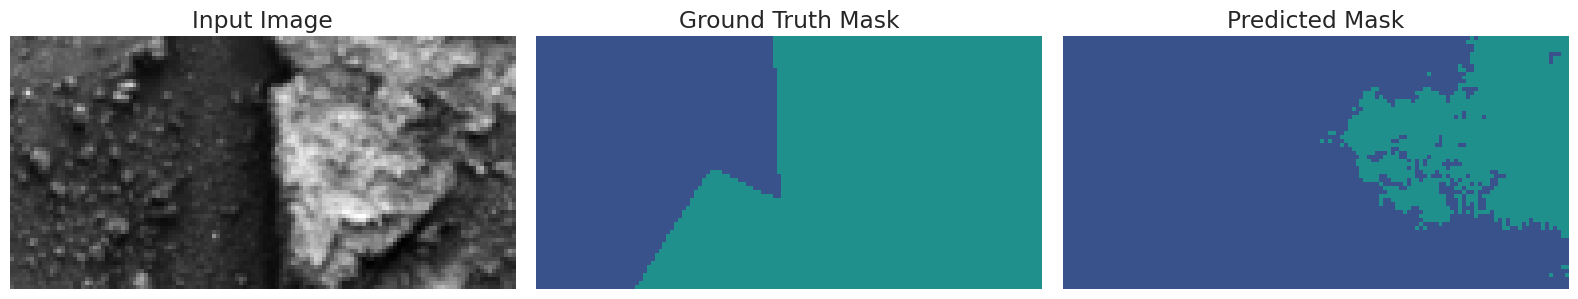

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - class1: 0.8551 - class2: 0.8270 - class3: 0.7706 - class4: 0.0065 - loss: 0.3582 - mean_iou: 0.4961 - val_class1: 0.6966 - val_class2: 0.5161 - val_class3: 0.6086 - val_class4: 0.0000e+00 - val_loss: 0.7289 - val_mean_iou: 0.3866
Epoch 57/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - class1: 0.7984 - class2: 0.7770 - class3: 0.7111 - class4: 0.0046 - loss: 0.4120 - mean_iou: 0.4632 - val_class1: 0.7388 - val_class2: 0.4673 - val_class3: 0.6033 - val_class4: 3.2206e-04 - val_loss: 0.7457 - val_mean_iou: 0.3729
Epoch 58/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - class1: 0.8296 - class2: 0.7964 - class3: 0.7626 - class4: 0.0057 - loss: 0.3827 - mean_iou: 0.4835 - val_class1: 0.6907 - val_class2: 0.4326 - val_class3: 0.6013 - val_class4: 0.0015 - val_loss: 0.7273 - val_mean_iou: 0.3645
Epoch 59/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.8582 - class2: 0.8173 - class3: 0.7777 - class4: 0.0037 - loss: 0.3622 - mean_iou: 0.4957 

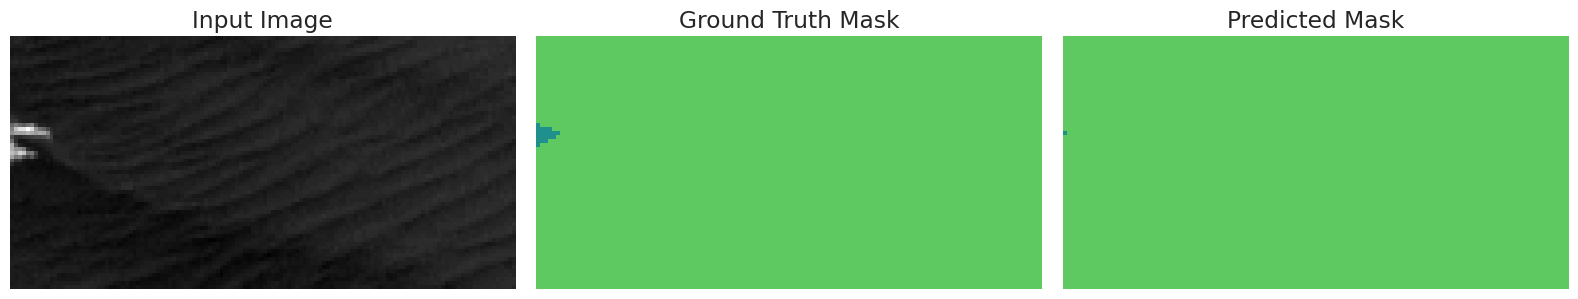

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step - class1: 0.8528 - class2: 0.8429 - class3: 0.7720 - class4: 0.0047 - loss: 0.3462 - mean_iou: 0.4989 - val_class1: 0.7290 - val_class2: 0.4760 - val_class3: 0.6186 - val_class4: 0.0000e+00 - val_loss: 0.7329 - val_mean_iou: 0.3794
Epoch 62/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.8080 - class2: 0.7852 - class3: 0.7523 - class4: 0.0027 - loss: 0.3836 - mean_iou: 0.4736 - val_class1: 0.6525 - val_class2: 0.5004 - val_class3: 0.6217 - val_class4: 0.0000e+00 - val_loss: 0.7758 - val_mean_iou: 0.3736
Epoch 63/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.8621 - class2: 0.8297 - class3: 0.7884 - class4: 0.0047 - loss: 0.3468 - mean_iou: 0.5011 - val_class1: 0.6355 - val_class2: 0.4841 - val_class3: 0.6004 - val_class4: 0.0000e+00 - val_loss: 0.7434 - val_mean_iou: 0.3576
Epoch 64/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - class1: 0.8802 - class2: 0.8745 - class3: 0.8040 - class4: 0.0060 - loss: 0.3231 - mean_iou: 0.5

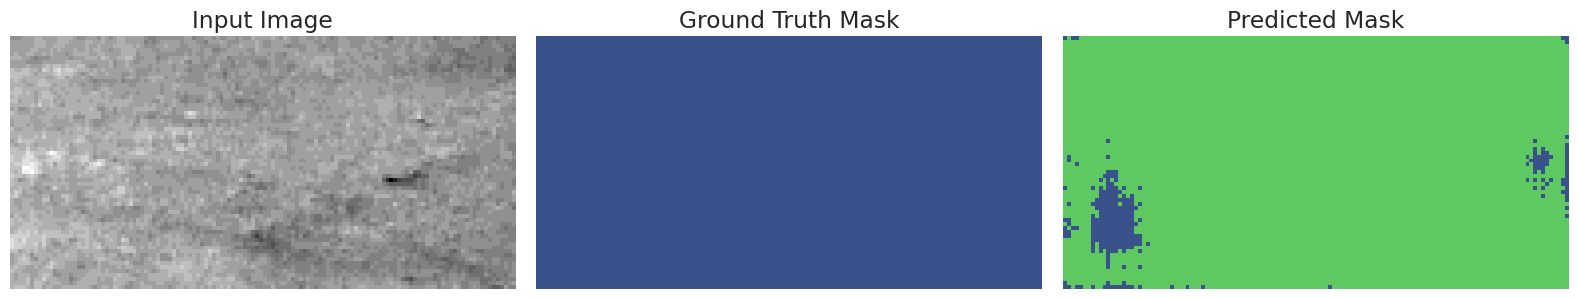

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - class1: 0.8872 - class2: 0.8739 - class3: 0.8061 - class4: 0.0152 - loss: 0.3196 - mean_iou: 0.5197 - val_class1: 0.7179 - val_class2: 0.5171 - val_class3: 0.6067 - val_class4: 0.0018 - val_loss: 0.6968 - val_mean_iou: 0.3909
Epoch 67/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.8630 - class2: 0.8560 - class3: 0.8107 - class4: 0.0122 - loss: 0.3254 - mean_iou: 0.5112 - val_class1: 0.7157 - val_class2: 0.4509 - val_class3: 0.6236 - val_class4: 0.0000e+00 - val_loss: 0.7104 - val_mean_iou: 0.3793
Epoch 68/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - class1: 0.8699 - class2: 0.8259 - class3: 0.8265 - class4: 0.0270 - loss: 0.3283 - mean_iou: 0.5129 - val_class1: 0.7237 - val_class2: 0.5369 - val_class3: 0.5622 - val_class4: 0.0036 - val_loss: 0.6417 - val_mean_iou: 0.3878
Epoch 69/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.8805 - class2: 0.8619 - class3: 0.8352 - class4: 0.0303 - loss: 0.3108 - mean_iou: 0.5245 - va

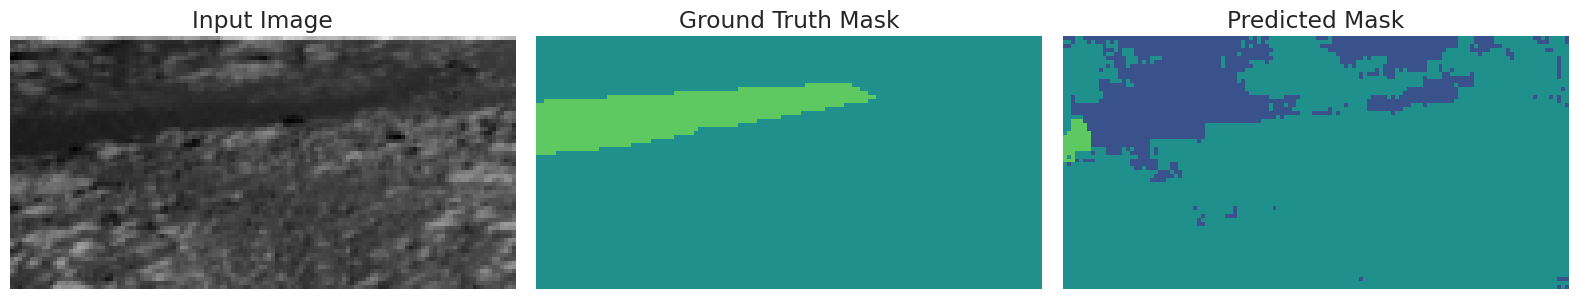

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - class1: 0.8958 - class2: 0.8798 - class3: 0.8366 - class4: 0.0512 - loss: 0.3001 - mean_iou: 0.5360 - val_class1: 0.6714 - val_class2: 0.4795 - val_class3: 0.6306 - val_class4: 0.0159 - val_loss: 0.6890 - val_mean_iou: 0.3797
Epoch 72/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - class1: 0.8978 - class2: 0.8770 - class3: 0.8438 - class4: 0.0386 - loss: 0.2973 - mean_iou: 0.5347 - val_class1: 0.6815 - val_class2: 0.5621 - val_class3: 0.5674 - val_class4: 0.0000e+00 - val_loss: 0.6542 - val_mean_iou: 0.3698
Epoch 73/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.8797 - class2: 0.8688 - class3: 0.8331 - class4: 0.0524 - loss: 0.3075 - mean_iou: 0.5305 - val_class1: 0.6865 - val_class2: 0.5728 - val_class3: 0.5864 - val_class4: 0.0000e+00 - val_loss: 0.6924 - val_mean_iou: 0.3866
Epoch 74/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.8797 - class2: 0.8775 - class3: 0.8138 - class4: 0.1377 - loss: 0.3035 - mean_iou: 0.5462 

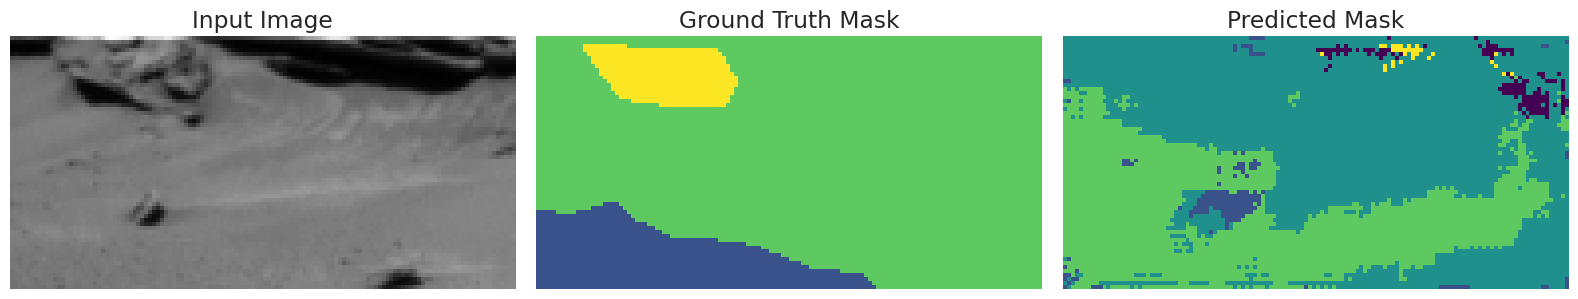

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - class1: 0.9028 - class2: 0.8934 - class3: 0.8477 - class4: 0.0982 - loss: 0.2837 - mean_iou: 0.5544 - val_class1: 0.7481 - val_class2: 0.5150 - val_class3: 0.5817 - val_class4: 0.0000e+00 - val_loss: 0.7081 - val_mean_iou: 0.4008
Epoch 77/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9054 - class2: 0.8999 - class3: 0.8540 - class4: 0.0882 - loss: 0.2803 - mean_iou: 0.5544 - val_class1: 0.7069 - val_class2: 0.5600 - val_class3: 0.5852 - val_class4: 0.0023 - val_loss: 0.6850 - val_mean_iou: 0.3825
Epoch 78/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - class1: 0.8884 - class2: 0.8494 - class3: 0.7983 - class4: 0.0986 - loss: 0.3088 - mean_iou: 0.5316 - val_class1: 0.6752 - val_class2: 0.5269 - val_class3: 0.6129 - val_class4: 0.0000e+00 - val_loss: 0.7313 - val_mean_iou: 0.3721
Epoch 79/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.8916 - class2: 0.8625 - class3: 0.8290 - class4: 0.1160 - loss: 0.2963 - mean_iou: 0.5457 

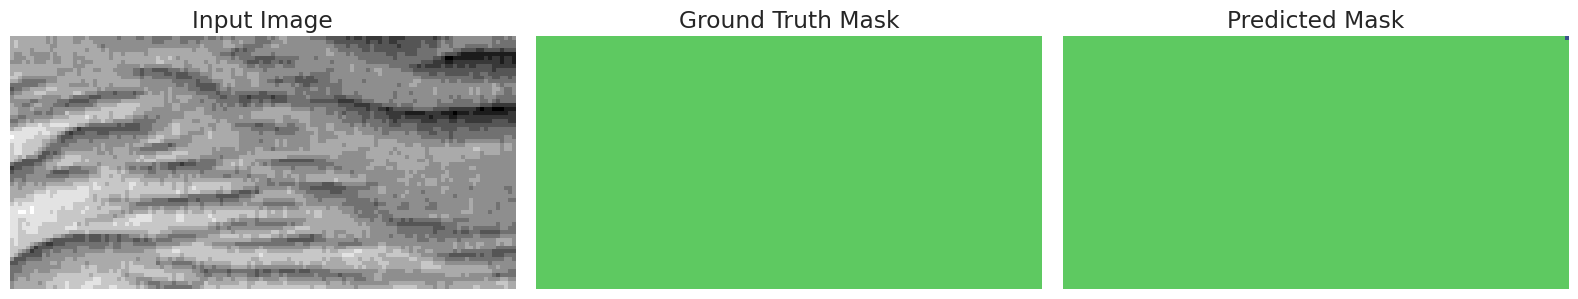

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - class1: 0.8911 - class2: 0.8758 - class3: 0.8547 - class4: 0.2139 - loss: 0.2739 - mean_iou: 0.5722 - val_class1: 0.7517 - val_class2: 0.5121 - val_class3: 0.5707 - val_class4: 0.0026 - val_loss: 0.6801 - val_mean_iou: 0.3816
Epoch 82/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.9006 - class2: 0.8830 - class3: 0.8456 - class4: 0.2158 - loss: 0.2770 - mean_iou: 0.5780 - val_class1: 0.7781 - val_class2: 0.5207 - val_class3: 0.5775 - val_class4: 0.0000e+00 - val_loss: 0.6802 - val_mean_iou: 0.3988
Epoch 83/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - class1: 0.9243 - class2: 0.9112 - class3: 0.8712 - class4: 0.2504 - loss: 0.2517 - mean_iou: 0.5996 - val_class1: 0.7245 - val_class2: 0.4804 - val_class3: 0.5414 - val_class4: 0.0000e+00 - val_loss: 0.7967 - val_mean_iou: 0.3834
Epoch 84/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.8884 - class2: 0.8908 - class3: 0.8436 - class4: 0.3405 - loss: 0.2623 - mean_iou: 0.5997 

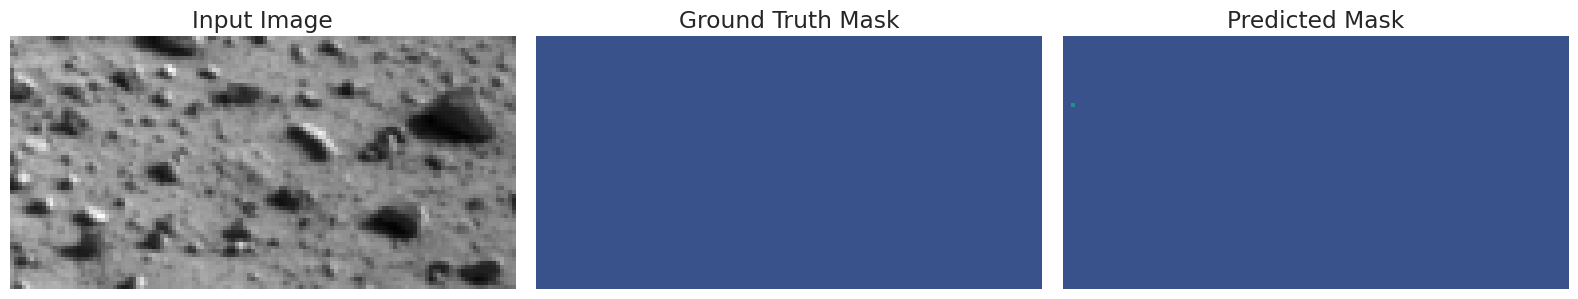

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - class1: 0.9050 - class2: 0.8972 - class3: 0.8532 - class4: 0.3016 - loss: 0.2425 - mean_iou: 0.5975 - val_class1: 0.7012 - val_class2: 0.5609 - val_class3: 0.5922 - val_class4: 0.0325 - val_loss: 0.6669 - val_mean_iou: 0.3921
Epoch 87/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.9134 - class2: 0.9144 - class3: 0.8628 - class4: 0.3954 - loss: 0.2250 - mean_iou: 0.6232 - val_class1: 0.6795 - val_class2: 0.3539 - val_class3: 0.5447 - val_class4: 0.0096 - val_loss: 0.8484 - val_mean_iou: 0.3394
Epoch 88/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9004 - class2: 0.8777 - class3: 0.8616 - class4: 0.3180 - loss: 0.2519 - mean_iou: 0.6021 - val_class1: 0.6635 - val_class2: 0.4747 - val_class3: 0.5172 - val_class4: 0.0000e+00 - val_loss: 0.7594 - val_mean_iou: 0.3492
Epoch 89/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9168 - class2: 0.8906 - class3: 0.8547 - class4: 0.3623 - loss: 0.2249 - mean_iou: 0.6138 - va

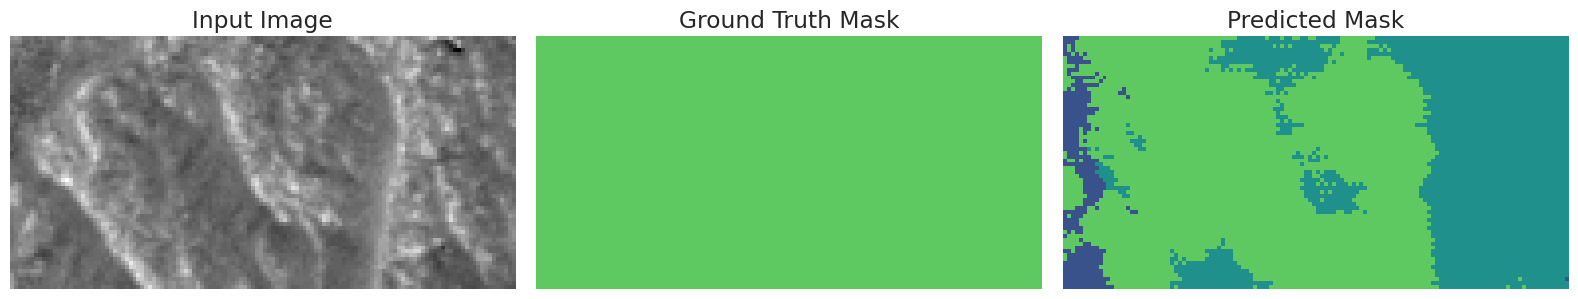

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - class1: 0.8951 - class2: 0.8808 - class3: 0.8458 - class4: 0.3741 - loss: 0.2465 - mean_iou: 0.6064 - val_class1: 0.7022 - val_class2: 0.5442 - val_class3: 0.5818 - val_class4: 0.0053 - val_loss: 0.6830 - val_mean_iou: 0.3773
Epoch 92/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - class1: 0.9305 - class2: 0.9124 - class3: 0.8836 - class4: 0.4178 - loss: 0.2121 - mean_iou: 0.6351 - val_class1: 0.6947 - val_class2: 0.5388 - val_class3: 0.5989 - val_class4: 0.0045 - val_loss: 0.7270 - val_mean_iou: 0.3899
Epoch 93/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - class1: 0.9249 - class2: 0.9186 - class3: 0.8885 - class4: 0.4662 - loss: 0.1986 - mean_iou: 0.6456 - val_class1: 0.7331 - val_class2: 0.5975 - val_class3: 0.6371 - val_class4: 0.0900 - val_loss: 0.5809 - val_mean_iou: 0.4190
Epoch 94/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9303 - class2: 0.9232 - class3: 0.8715 - class4: 0.4502 - loss: 0.1970 - mean_iou: 0.6399 - val_cl

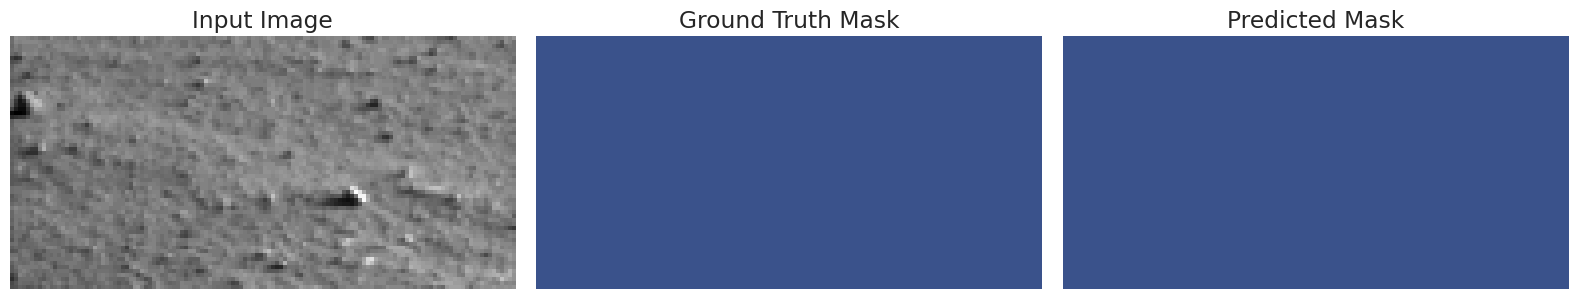

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - class1: 0.9103 - class2: 0.9013 - class3: 0.8788 - class4: 0.5374 - loss: 0.1908 - mean_iou: 0.6498 - val_class1: 0.7366 - val_class2: 0.5465 - val_class3: 0.6190 - val_class4: 0.0591 - val_loss: 0.6745 - val_mean_iou: 0.4128
Epoch 97/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - class1: 0.9037 - class2: 0.8996 - class3: 0.8727 - class4: 0.4606 - loss: 0.2115 - mean_iou: 0.6349 - val_class1: 0.7061 - val_class2: 0.5075 - val_class3: 0.5559 - val_class4: 0.0795 - val_loss: 0.7046 - val_mean_iou: 0.3827
Epoch 98/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - class1: 0.9093 - class2: 0.8917 - class3: 0.8817 - class4: 0.4525 - loss: 0.2220 - mean_iou: 0.6349 - val_class1: 0.7531 - val_class2: 0.5366 - val_class3: 0.6091 - val_class4: 0.0010 - val_loss: 0.6201 - val_mean_iou: 0.3895
Epoch 99/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - class1: 0.9301 - class2: 0.9176 - class3: 0.8983 - class4: 0.5661 - loss: 0.1782 - mean_iou: 0.6664 - val_cl

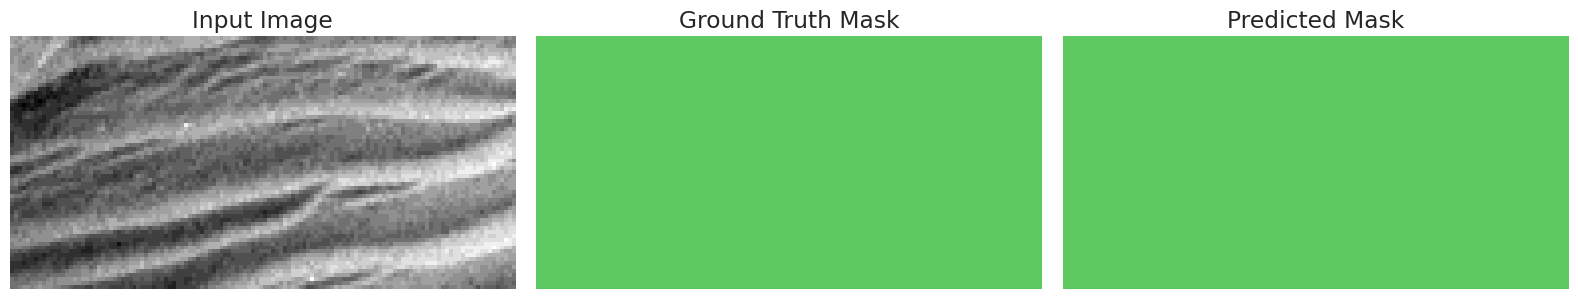

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - class1: 0.9234 - class2: 0.9222 - class3: 0.8583 - class4: 0.5564 - loss: 0.1881 - mean_iou: 0.6568 - val_class1: 0.7340 - val_class2: 0.4955 - val_class3: 0.6405 - val_class4: 0.0484 - val_loss: 0.7648 - val_mean_iou: 0.4007
Epoch 102/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.9324 - class2: 0.9217 - class3: 0.8814 - class4: 0.5368 - loss: 0.1835 - mean_iou: 0.6589 - val_class1: 0.7260 - val_class2: 0.5895 - val_class3: 0.6563 - val_class4: 0.0446 - val_loss: 0.6171 - val_mean_iou: 0.4199
Epoch 103/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - class1: 0.9462 - class2: 0.9415 - class3: 0.8970 - class4: 0.5859 - loss: 0.1484 - mean_iou: 0.6774 - val_class1: 0.7338 - val_class2: 0.4988 - val_class3: 0.6360 - val_class4: 0.0179 - val_loss: 0.6837 - val_mean_iou: 0.3975
Epoch 104/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.9326 - class2: 0.9228 - class3: 0.8673 - class4: 0.6106 - loss: 0.1713 - mean_iou: 0.6708 - val

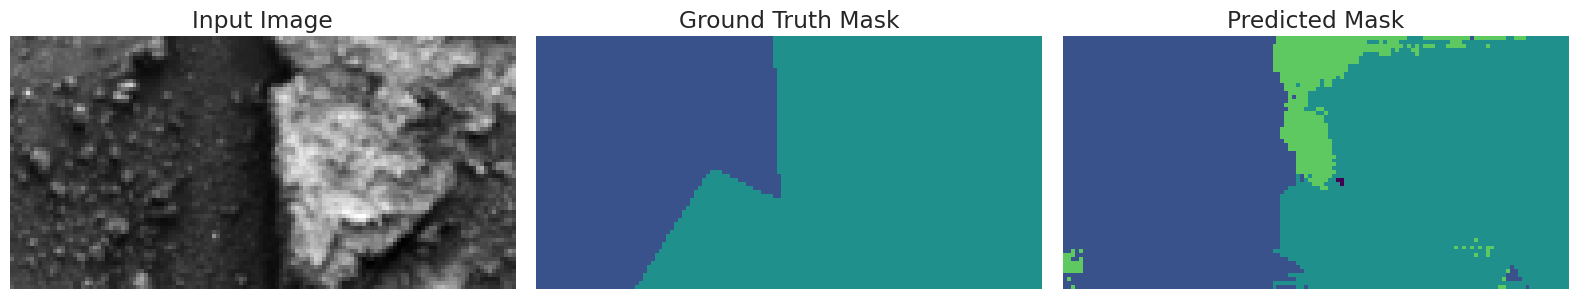

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - class1: 0.9140 - class2: 0.9104 - class3: 0.8615 - class4: 0.5935 - loss: 0.1815 - mean_iou: 0.6599 - val_class1: 0.6370 - val_class2: 0.4617 - val_class3: 0.6096 - val_class4: 0.0000e+00 - val_loss: 0.7596 - val_mean_iou: 0.3481
Epoch 107/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - class1: 0.9381 - class2: 0.9320 - class3: 0.8899 - class4: 0.6185 - loss: 0.1552 - mean_iou: 0.6800 - val_class1: 0.7477 - val_class2: 0.4743 - val_class3: 0.6235 - val_class4: 0.0408 - val_loss: 0.7304 - val_mean_iou: 0.4045
Epoch 108/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - class1: 0.9368 - class2: 0.9305 - class3: 0.8901 - class4: 0.6502 - loss: 0.1534 - mean_iou: 0.6862 - val_class1: 0.7193 - val_class2: 0.5022 - val_class3: 0.6315 - val_class4: 0.1031 - val_loss: 0.6497 - val_mean_iou: 0.4148
Epoch 109/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - class1: 0.9435 - class2: 0.9398 - class3: 0.8966 - class4: 0.6654 - loss: 0.1510 - mean_iou: 0.6923 -

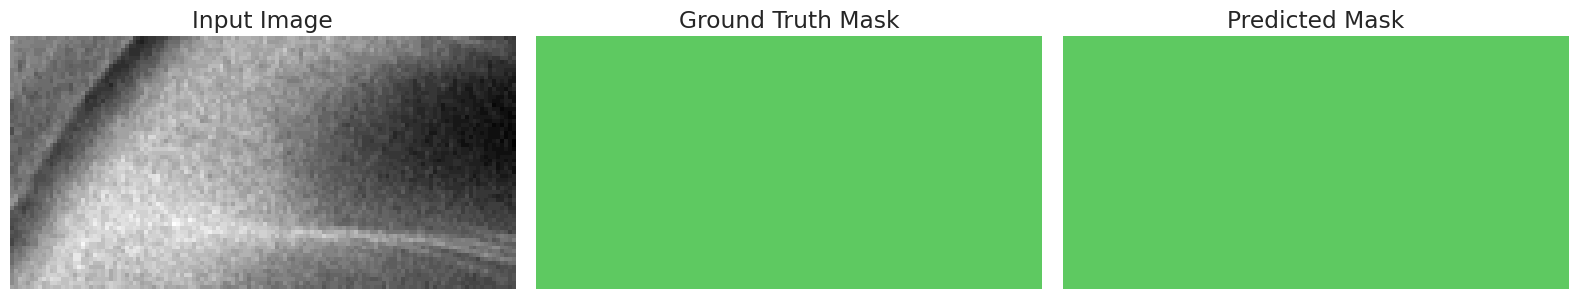

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - class1: 0.9338 - class2: 0.9200 - class3: 0.8843 - class4: 0.7586 - loss: 0.1419 - mean_iou: 0.7049 - val_class1: 0.7756 - val_class2: 0.5618 - val_class3: 0.6681 - val_class4: 0.0063 - val_loss: 0.6035 - val_mean_iou: 0.4225
Epoch 112/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.9336 - class2: 0.9286 - class3: 0.8948 - class4: 0.7812 - loss: 0.1390 - mean_iou: 0.7107 - val_class1: 0.7128 - val_class2: 0.5277 - val_class3: 0.6132 - val_class4: 0.0526 - val_loss: 0.6895 - val_mean_iou: 0.4033
Epoch 113/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.9310 - class2: 0.9260 - class3: 0.8947 - class4: 0.7151 - loss: 0.1445 - mean_iou: 0.6968 - val_class1: 0.6707 - val_class2: 0.4845 - val_class3: 0.6097 - val_class4: 0.0000e+00 - val_loss: 0.6608 - val_mean_iou: 0.3605
Epoch 114/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - class1: 0.9453 - class2: 0.9387 - class3: 0.9062 - class4: 0.7432 - loss: 0.1231 - mean_iou: 0.7116 -

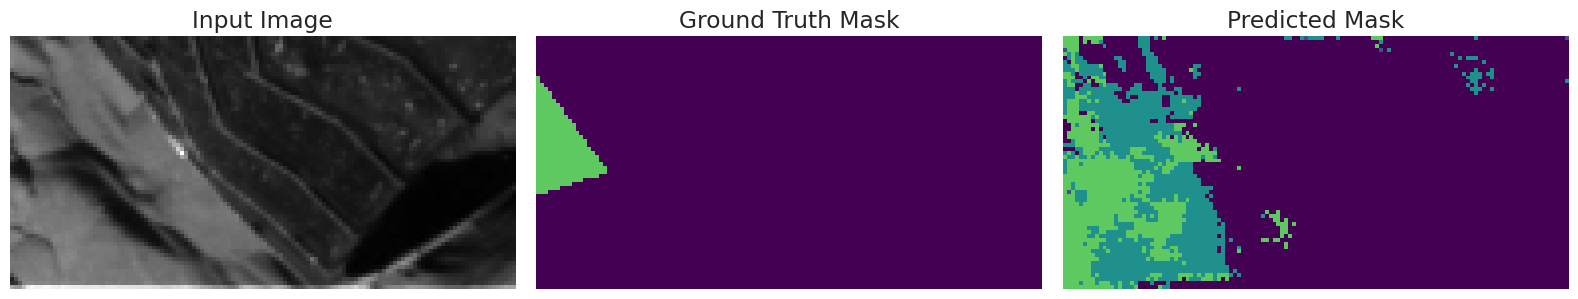

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - class1: 0.9458 - class2: 0.9257 - class3: 0.9151 - class4: 0.7348 - loss: 0.1323 - mean_iou: 0.7122 - val_class1: 0.6904 - val_class2: 0.3684 - val_class3: 0.5475 - val_class4: 0.0841 - val_loss: 0.7385 - val_mean_iou: 0.3475
Epoch 117/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.9188 - class2: 0.9007 - class3: 0.8899 - class4: 0.7477 - loss: 0.1345 - mean_iou: 0.6951 - val_class1: 0.6461 - val_class2: 0.4717 - val_class3: 0.5286 - val_class4: 0.0226 - val_loss: 0.7125 - val_mean_iou: 0.3435
Epoch 118/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - class1: 0.9102 - class2: 0.9118 - class3: 0.8390 - class4: 0.7441 - loss: 0.1544 - mean_iou: 0.6863 - val_class1: 0.7195 - val_class2: 0.5693 - val_class3: 0.4979 - val_class4: 0.0000e+00 - val_loss: 0.6709 - val_mean_iou: 0.3681
Epoch 119/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9356 - class2: 0.9391 - class3: 0.8654 - class4: 0.7738 - loss: 0.1260 - mean_iou: 0.7065 -

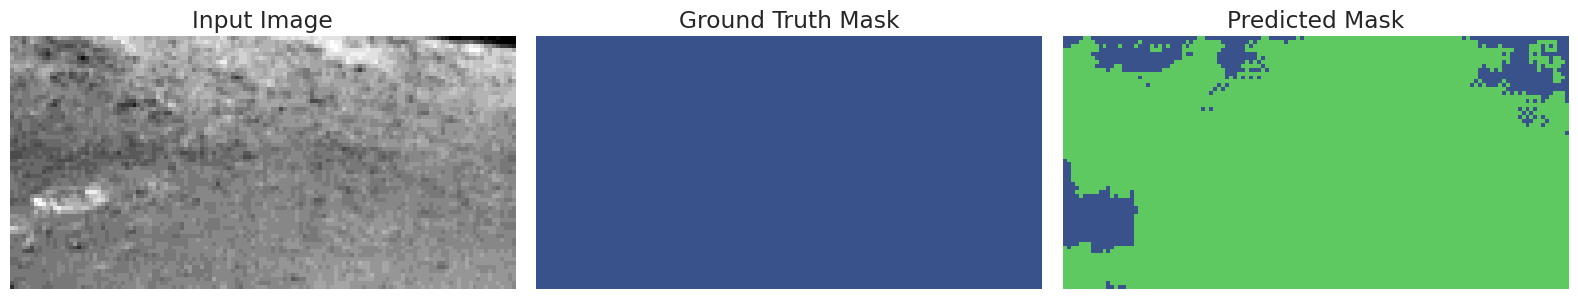

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - class1: 0.9588 - class2: 0.9556 - class3: 0.9215 - class4: 0.8289 - loss: 0.0878 - mean_iou: 0.7360 - val_class1: 0.7151 - val_class2: 0.4979 - val_class3: 0.6377 - val_class4: 0.0208 - val_loss: 0.7079 - val_mean_iou: 0.3908
Epoch 122/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - class1: 0.9613 - class2: 0.9556 - class3: 0.9259 - class4: 0.8286 - loss: 0.0957 - mean_iou: 0.7375 - val_class1: 0.6816 - val_class2: 0.4757 - val_class3: 0.5666 - val_class4: 0.0835 - val_loss: 0.7681 - val_mean_iou: 0.3816
Epoch 123/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - class1: 0.9463 - class2: 0.9493 - class3: 0.9033 - class4: 0.8634 - loss: 0.1048 - mean_iou: 0.7352 - val_class1: 0.6580 - val_class2: 0.3548 - val_class3: 0.6516 - val_class4: 0.0671 - val_loss: 0.7573 - val_mean_iou: 0.3611
Epoch 124/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - class1: 0.9417 - class2: 0.9427 - class3: 0.9067 - class4: 0.8520 - loss: 0.0976 - mean_iou: 0.7315 - val

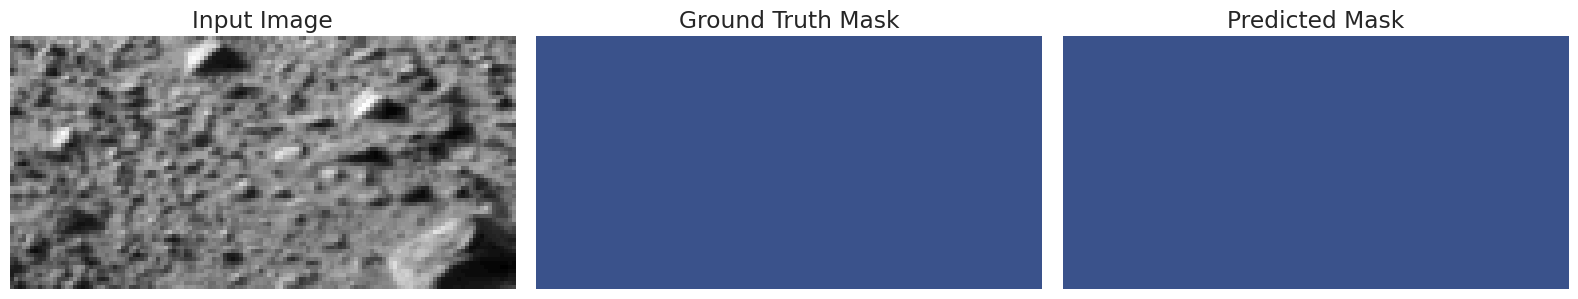

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - class1: 0.9525 - class2: 0.9521 - class3: 0.9171 - class4: 0.8060 - loss: 0.1017 - mean_iou: 0.7290 - val_class1: 0.7218 - val_class2: 0.5438 - val_class3: 0.5652 - val_class4: 0.0000e+00 - val_loss: 0.7346 - val_mean_iou: 0.3821
Epoch 127/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - class1: 0.9604 - class2: 0.9543 - class3: 0.9203 - class4: 0.8289 - loss: 0.0825 - mean_iou: 0.7356 - val_class1: 0.7301 - val_class2: 0.5686 - val_class3: 0.5875 - val_class4: 0.0212 - val_loss: 0.6995 - val_mean_iou: 0.3933
Epoch 128/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - class1: 0.9640 - class2: 0.9498 - class3: 0.9250 - class4: 0.8236 - loss: 0.1115 - mean_iou: 0.7399 - val_class1: 0.7365 - val_class2: 0.5396 - val_class3: 0.6018 - val_class4: 0.0000e+00 - val_loss: 0.6869 - val_mean_iou: 0.3940
Epoch 129/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - class1: 0.9495 - class2: 0.9455 - class3: 0.9068 - class4: 0.8677 - loss: 0.0991 - mean_iou: 0.73

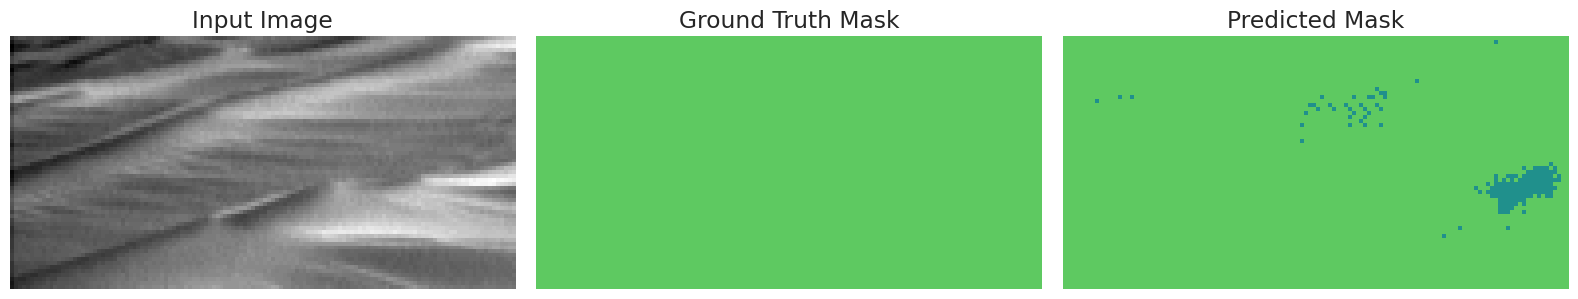

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - class1: 0.9406 - class2: 0.9346 - class3: 0.9164 - class4: 0.8542 - loss: 0.1006 - mean_iou: 0.7321 - val_class1: 0.6721 - val_class2: 0.5403 - val_class3: 0.6156 - val_class4: 0.0000e+00 - val_loss: 0.6984 - val_mean_iou: 0.3837
Epoch 132/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - class1: 0.9294 - class2: 0.9379 - class3: 0.8797 - class4: 0.7808 - loss: 0.1129 - mean_iou: 0.7101 - val_class1: 0.6982 - val_class2: 0.5263 - val_class3: 0.5087 - val_class4: 0.0000e+00 - val_loss: 0.7218 - val_mean_iou: 0.3576
Epoch 133/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9521 - class2: 0.9424 - class3: 0.9183 - class4: 0.8425 - loss: 0.0918 - mean_iou: 0.7343 - val_class1: 0.7131 - val_class2: 0.5714 - val_class3: 0.5949 - val_class4: 2.1395e-04 - val_loss: 0.6873 - val_mean_iou: 0.3922
Epoch 134/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9514 - class2: 0.9539 - class3: 0.9050 - class4: 0.8167 - loss: 0.1100 - mean_iou: 

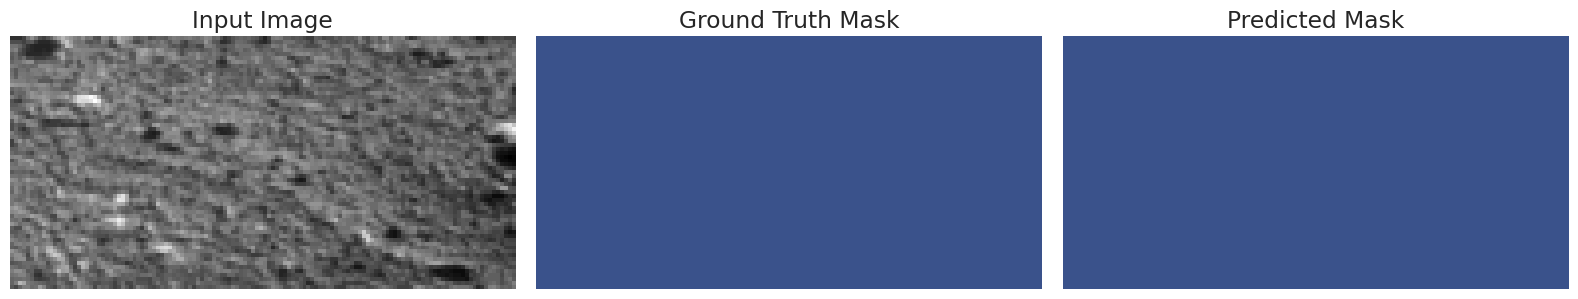

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - class1: 0.9367 - class2: 0.9397 - class3: 0.8887 - class4: 0.8728 - loss: 0.0929 - mean_iou: 0.7306 - val_class1: 0.7541 - val_class2: 0.5426 - val_class3: 0.6149 - val_class4: 0.0188 - val_loss: 0.6457 - val_mean_iou: 0.3970
Epoch 137/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9553 - class2: 0.9493 - class3: 0.9143 - class4: 0.8808 - loss: 0.0984 - mean_iou: 0.7424 - val_class1: 0.7185 - val_class2: 0.5457 - val_class3: 0.6439 - val_class4: 0.0048 - val_loss: 0.6802 - val_mean_iou: 0.3994
Epoch 138/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - class1: 0.9471 - class2: 0.9459 - class3: 0.9059 - class4: 0.8681 - loss: 0.0916 - mean_iou: 0.7367 - val_class1: 0.7012 - val_class2: 0.4668 - val_class3: 0.6355 - val_class4: 0.0000e+00 - val_loss: 0.7451 - val_mean_iou: 0.3784
Epoch 139/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - class1: 0.9455 - class2: 0.9468 - class3: 0.8982 - class4: 0.8817 - loss: 0.0903 - mean_iou: 0.7367 -

In [ ]:
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        verbose=1,
    ).history

    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

## 📊 Model Evaluation: Assessing Performance and MIoU


In [ ]:
target_class = 4
num_images_with_class = sum(target_class in np.unique(y) for y in y_val)
print(f"Class {target_class} is present in {num_images_with_class} images.")

# Find indices of the images containing pixels labelled as target class
indices_with_class = [idx for idx, y in enumerate(y_val) if target_class in np.unique(y)]

preds= tf.math.argmax(model.predict(X_val), axis=-1)

for idx in indices_with_class:
    plt.figure(figsize=(8, 4))

    print("Img " + str(idx))

    # Mask
    plt.subplot(1, 2, 1)
    colormap = plt.cm.viridis(np.linspace(0, 1, 5))
    colored_label = apply_colormap(y_val[idx], colormap)
    plt.imshow(colored_label)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Original Image
    plt.subplot(1, 2, 2)
    colormap = plt.cm.viridis(np.linspace(0, 1, 5))
    colored_label = apply_colormap(preds[idx], colormap)
    plt.imshow(X_val[idx], cmap="gray")
    plt.title("Image")
    plt.axis('off')

    plt.show()

In [ ]:
y_pred = model.predict(X_val)

### Show training's plots

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
model.evaluate(test_dataset)

### Show confusion matrix

In [ ]:
def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data.

    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """
    # Get ground-truth labels and model predictions
    y_true = []
    y_pred = []

    for inputs, labels in test_data:
        predictions = model.predict(inputs)
        y_true.extend(np.argmax(labels.numpy(), axis=-1))
        y_pred.extend(np.argmax(predictions, axis=-1))

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_dataset, [0, 1, 2, 3, 4])

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

## 💾 Save Model's prediction

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = int(time())
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)